# Project 3: Supervised vs Unsupervised Anomaly Detection
## Task 1: Dataset Characterization and Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from pathlib import Path

import random
import torch


In [2]:
# ============================================================================
# REPORT-COMPLIANT PLOT CONFIGURATION
# ============================================================================
# Set consistent style for all plots
plt.style.use('seaborn-v0_8-whitegrid')

# Global matplotlib parameters for report-quality figures
plt.rcParams.update({
    # Figure size (width, height) in inches - suitable for reports
    'figure.figsize': (8, 5),
    'figure.dpi': 150,

    # Font sizes
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'legend.title_fontsize': 11,

    # Font weight
    'axes.titleweight': 'bold',
    'axes.labelweight': 'bold',

    # Line widths
    'axes.linewidth': 1.2,
    'grid.linewidth': 0.8,
    'lines.linewidth': 1.5,

    # Grid style
    'grid.alpha': 0.3,
    'grid.linestyle': '--',

    # Save figure settings
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
})

# Color palette for consistency
REPORT_COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'tertiary': '#F18F01',
    'quaternary': '#C73E1D',
    'normal': '#2E86AB',
    'anomaly': '#F18F01'
}
# ============================================================================

## Helper functions

In [3]:
# ============================================================================
# GLOBAL CONFIGURATION: Plot Saving
# ============================================================================
SAVE_PLOTS = False
# ============================================================================

REPORT_IMAGES_DIR = '../Plots/Task1'
os.makedirs(REPORT_IMAGES_DIR, exist_ok=True)

def save_figure_for_report(filename, dpi=300, bbox_inches='tight'):
    """
    Persist the current matplotlib figure under the Task 1 plots directory.

    Args:
        filename: Target filename such as 'task1_class_distribution.png'.
        dpi: Output resolution (defaults to 300).
        bbox_inches: Matplotlib bounding box mode (defaults to 'tight').
    """
    if not SAVE_PLOTS or not filename:
        return

    filepath = os.path.join(REPORT_IMAGES_DIR, filename)
    plt.savefig(filepath, dpi=dpi, bbox_inches=bbox_inches)
    print(f"Figure saved to: {filepath}")

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The device is set to: {device}")

The device is set to: cpu


In [5]:
# Seed al the libraries to ensure reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # for multi-GPU setups

# Example: setting a seed for reproducibility
set_seed(42)

## Dataset loading and characterization

In [6]:
df_train_val = pd.read_csv('../data/raw/train.csv')
df_test = pd.read_csv('../data/raw/test.csv')

In [7]:
df_train_val

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,binary_label
0,0,udp,private,SF,28,0,0,3,0,0,...,0.36,0.65,0.36,0.00,0.09,0.0,0.56,0.0,dos,1
1,0,icmp,eco_i,SF,8,0,0,0,0,0,...,1.00,0.00,1.00,0.50,0.00,0.0,0.00,0.0,probe,1
2,0,tcp,daytime,S0,0,0,0,0,0,0,...,0.02,0.05,0.00,0.00,1.00,1.0,0.00,0.0,dos,1
3,0,tcp,http,SF,216,3396,0,0,0,0,...,1.00,0.00,0.14,0.02,0.00,0.0,0.00,0.0,normal,0
4,0,tcp,http,SF,348,277,0,0,0,0,...,1.00,0.00,0.01,0.07,0.00,0.0,0.00,0.0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18826,0,tcp,http,SF,328,1231,0,0,0,0,...,1.00,0.00,0.02,0.02,0.00,0.0,0.00,0.0,normal,0
18827,0,tcp,http,SF,214,928,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,normal,0
18828,0,tcp,http,SF,253,11905,0,0,0,0,...,1.00,0.00,0.01,0.02,0.00,0.0,0.00,0.0,normal,0
18829,0,tcp,uucp_path,S0,0,0,0,0,0,0,...,0.05,0.07,0.00,0.00,1.00,1.0,0.00,0.0,dos,1


Print the first 10 unique values in each column.

In [8]:
for column in df_train_val.columns:
    print(f"{column}: {df_train_val[column].unique()[0:10]}")

duration: [    0     1 12773    32     2   191    28    25     8    11]
protocol_type: ['udp' 'icmp' 'tcp']
service: ['private' 'eco_i' 'daytime' 'http' 'exec' 'smtp' 'ftp_data' 'ssh'
 'domain_u' 'other']
flag: ['SF' 'S0' 'REJ' 'RSTO' 'RSTR' 'S2' 'S1' 'SH' 'RSTOS0' 'S3']
src_bytes: [  28    8    0  216  348  845   18 1484  309  210]
dst_bytes: [   0 3396  277  328  335 7263  255  114 8513 3200]
land: [0 1]
wrong_fragment: [3 0 1]
urgent: [0]
hot: [ 0 28  2 14  4  1  6 30 19 22]
num_failed_logins: [0 2 1 4 3]
logged_in: [0 1]
num_compromised: [  0   1   6 157 520   5   2   9 217  12]
root_shell: [0 1]
su_attempted: [0 2 1]
num_root: [  0   2   1 179 572   6 247   5 121  10]
num_file_creations: [ 0  1  2 38 14 29  4 13  8 20]
num_shells: [0 1]
num_access_files: [0 1 8 4 5 3 2]
num_outbound_cmds: [0]
is_host_login: [0]
is_guest_login: [0 1]
count: [191   1 246   5   2 140  11   6 204   7]
srv_count: [91 11  5  2 12  1 14  4  7 21]
serror_rate: [0.52 0.   1.   0.09 0.33 0.05 0.07 0.5  0.04

In [9]:
df_test

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,binary_label
0,0,udp,private,SF,1,0,0,0,0,0,...,0.03,0.85,1.00,0.0,0.0,0.0,0.0,0.0,normal,0
1,0,udp,private,SF,55,51,0,0,0,0,...,1.00,0.00,0.99,0.0,0.0,0.0,0.0,0.0,normal,0
2,0,tcp,login,RSTO,0,0,0,0,0,0,...,0.07,0.06,0.00,0.0,0.0,0.0,1.0,1.0,dos,1
3,0,tcp,ftp,S0,0,0,0,0,0,0,...,0.00,0.11,0.00,0.0,1.0,1.0,0.0,0.0,dos,1
4,0,tcp,courier,REJ,0,0,0,0,0,0,...,0.07,0.05,0.00,0.0,0.0,0.0,1.0,1.0,dos,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5821,0,udp,domain_u,SF,46,85,0,0,0,0,...,1.00,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal,0
5822,0,udp,domain_u,SF,45,45,0,0,0,0,...,0.89,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal,0
5823,0,udp,domain_u,SF,44,79,0,0,0,0,...,1.00,0.00,0.01,0.0,0.0,0.0,0.0,0.0,normal,0
5824,0,udp,private,SF,54,52,0,0,0,0,...,1.00,0.00,0.84,0.0,0.0,0.0,0.0,0.0,normal,0


### Class Imbalance Analysis
Let's see the class distribution of the data from train.csv.

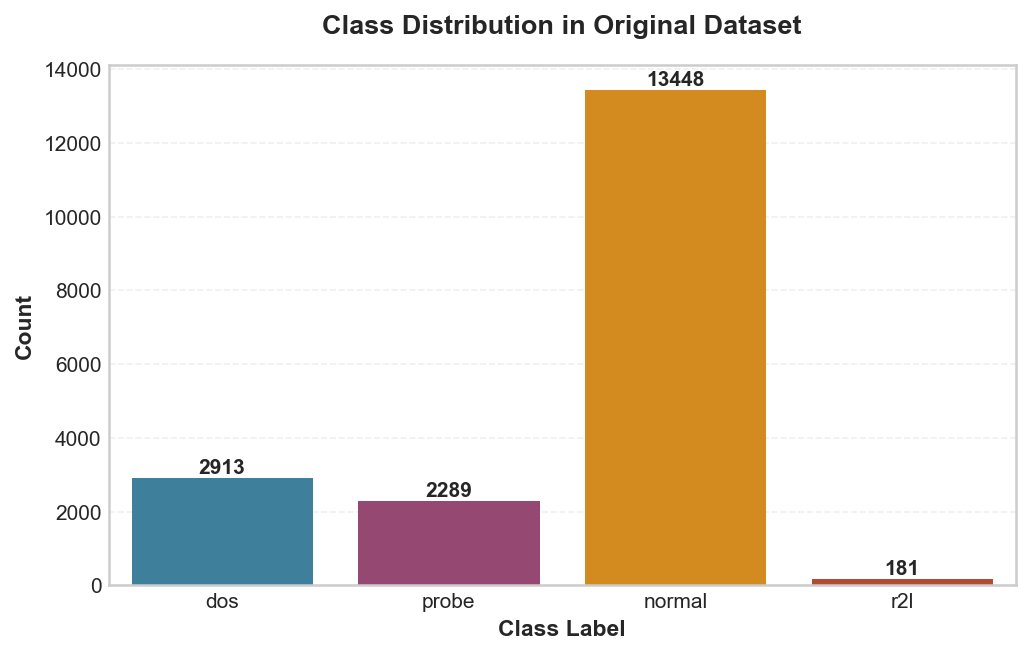

In [10]:
plt.figure(figsize=(7, 4.5))
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
ax = sns.countplot(data=df_train_val, x='label', hue='label', palette=colors, legend=False)

# Add count labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fontsize=10, fontweight='bold')

plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Class Distribution in Original Dataset', pad=15)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
save_figure_for_report('task1_attack_label_distribution.png')
plt.show()

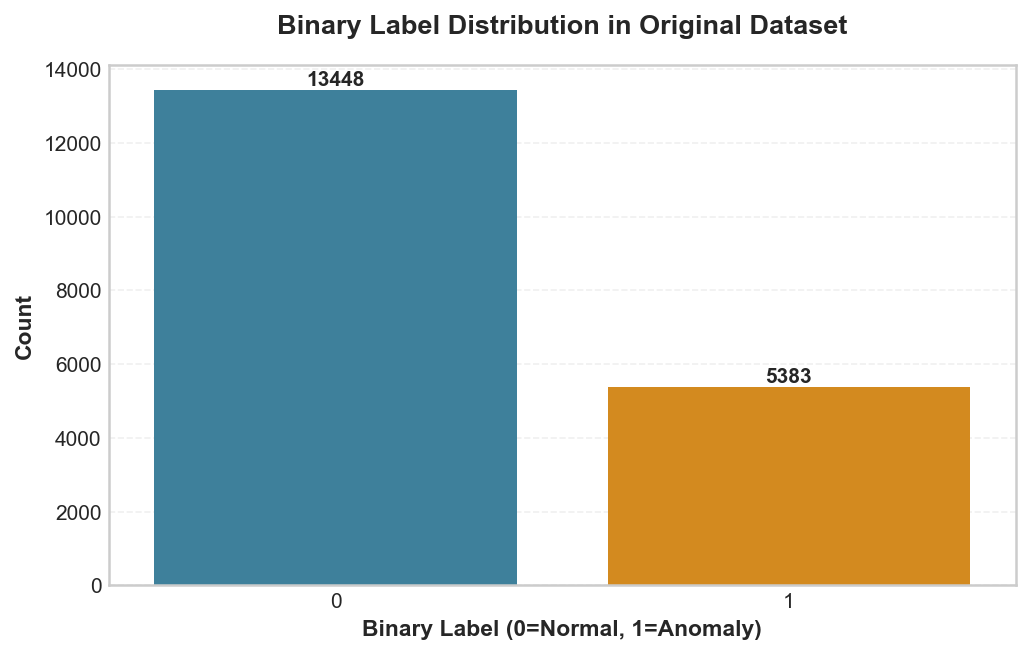

In [11]:
plt.figure(figsize=(7, 4.5))
colors = ['#2E86AB', '#F18F01']
ax = sns.countplot(data=df_train_val, x='binary_label', hue='binary_label', palette=colors, legend=False)

# Add count labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fontsize=10, fontweight='bold')

plt.xlabel('Binary Label (0=Normal, 1=Anomaly)')
plt.ylabel('Count')
plt.title('Binary Label Distribution in Original Dataset', pad=15)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
save_figure_for_report('task1_binary_label_distribution.png')
plt.show()

The pie charts below provide a proportional view of the class distribution, which is crucial for understanding the dataset imbalance. Class imbalance significantly impacts the choice of evaluation metrics (e.g., F1-score over accuracy) and may require techniques like stratified sampling during training.

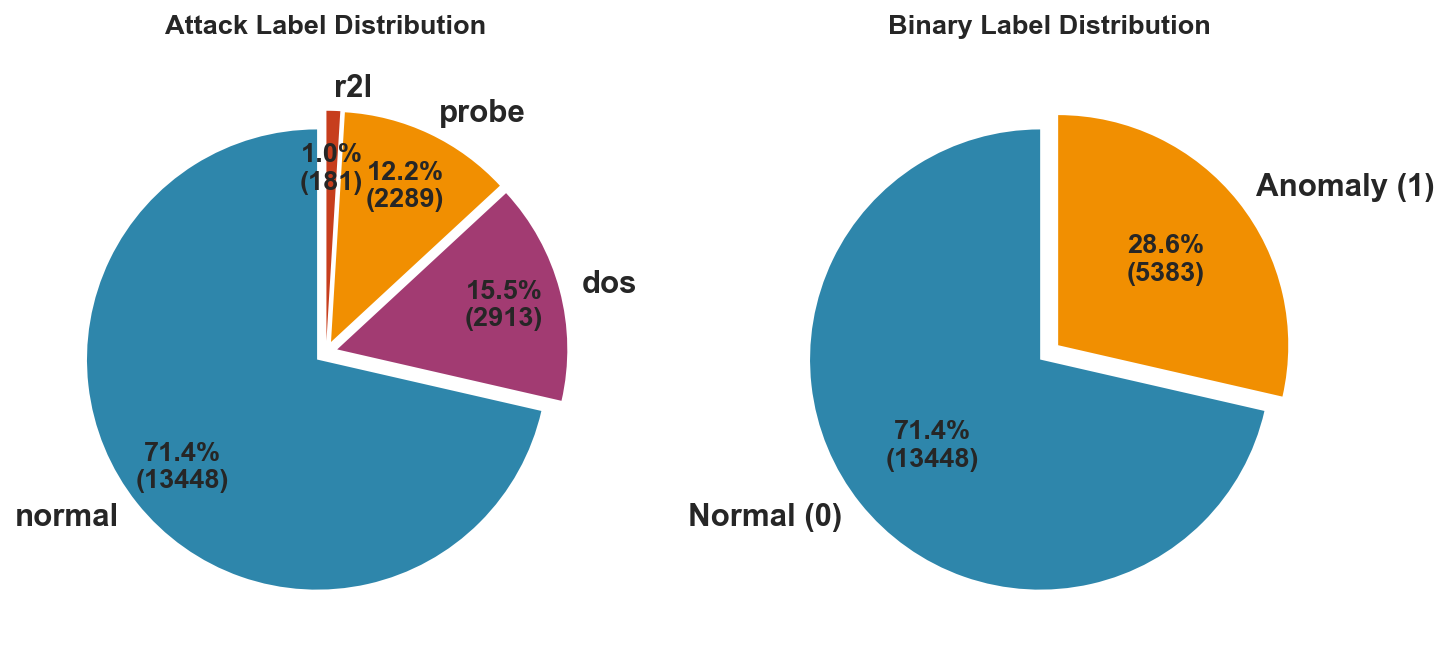


CLASS DISTRIBUTION SUMMARY

Binary Label Distribution:
  Normal:  13,448 (71.41%)
  Anomaly: 5,383 (28.59%)

Attack Label Distribution:
  normal: 13,448 (71.41%)
  dos: 2,913 (15.47%)
  probe: 2,289 (12.16%)
  r2l: 181 (0.96%)


In [12]:
# Pie charts for class distribution - provides proportional view
def autopct_format(values):
    def my_format(pct):
        total = len(values)
        val = int(round(pct*total/100.0))
        return '{:.1f}%\n({v:d})'.format(pct, v=val)
    return my_format

fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))

# Attack label distribution (pie)
attack_counts = df_train_val['label'].value_counts()
colors_attack = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
wedges1, texts1, autotexts1 = axes[0].pie(attack_counts, labels=attack_counts.index, autopct=autopct_format(df_train_val['label']), pctdistance=0.75,
            colors=colors_attack, startangle=90, explode=[0.05]*len(attack_counts),
            textprops={'fontsize': 15, 'fontweight': 'bold'})
for autotext in autotexts1:
    autotext.set_fontsize(13)
    autotext.set_fontweight('bold')
axes[0].set_title('Attack Label Distribution', fontsize=13, fontweight='bold', pad=15)

# Binary label distribution (pie)
binary_counts = df_train_val['binary_label'].value_counts().sort_index()
colors_binary = ['#2E86AB', '#F18F01']
labels_binary = ['Normal (0)', 'Anomaly (1)']
wedges2, texts2, autotexts2 = axes[1].pie(binary_counts, labels=labels_binary, autopct=autopct_format(df_train_val['binary_label']),
            colors=colors_binary, startangle=90, explode=[0.05, 0.05],
            textprops={'fontsize': 15,  'fontweight': 'bold'})
for autotext in autotexts2:
    autotext.set_fontsize(13)
    autotext.set_fontweight('bold')
axes[1].set_title('Binary Label Distribution', fontsize=13, fontweight='bold', pad=15)

plt.tight_layout()
save_figure_for_report('task1_class_distribution_pie.png')
plt.show()

# Print exact percentages for reference
print("\n" + "="*60)
print("CLASS DISTRIBUTION SUMMARY")

print("="*60)
print("="*60)


print(f"\nBinary Label Distribution:")
print(f"  Normal:  {binary_counts[0]:,} ({binary_counts[0]/len(df_train_val)*100:.2f}%)")
print(f"  Anomaly: {binary_counts[1]:,} ({binary_counts[1]/len(df_train_val)*100:.2f}%)")

print("\nAttack Label Distribution:")
for label, count in attack_counts.items():
    print(f"  {label}: {count:,} ({count/len(df_train_val)*100:.2f}%)")


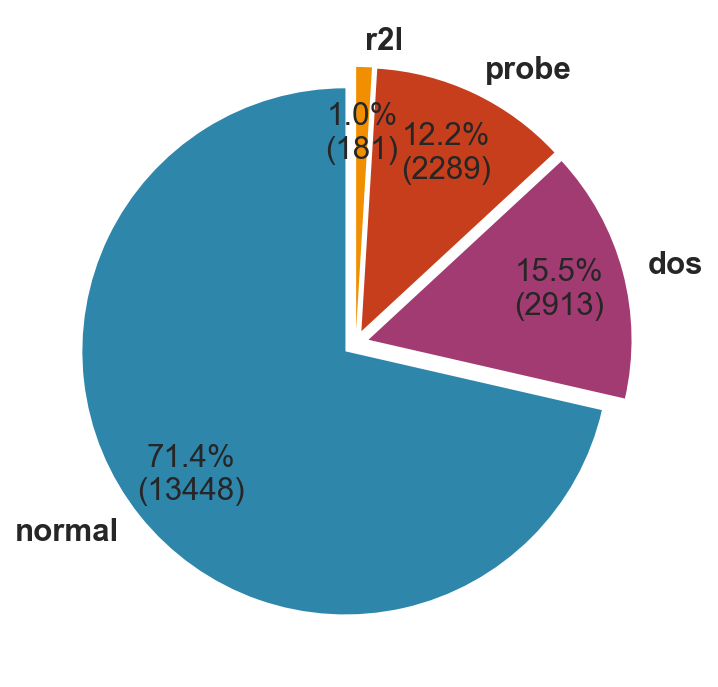

In [13]:
# Pie charts for class distribution - provides proportional view
def autopct_format(values):
    def my_format(pct):
        total = len(values)
        val = int(round(pct*total/100.0))
        return '{:.1f}%\n({v:d})'.format(pct, v=val)
    return my_format

plt.figure(figsize=(5, 5))

# Attack label distribution (pie)
attack_counts = df_train_val['label'].value_counts()
colors_attack = ['#2E86AB', '#A23B72', '#C73E1D', '#F18F01']
wedges1, texts1, autotexts1 = plt.pie(attack_counts, labels=attack_counts.index, autopct=autopct_format(df_train_val['label']), pctdistance=0.75,
            colors=colors_attack, startangle=90, explode=[0.05]*len(attack_counts),
            textprops={'fontsize': 15, 'fontweight': 'bold'})
for autotext in autotexts1:
    autotext.set_fontsize(15)
    autotext.set_fontweight('normal')

plt.tight_layout()
save_figure_for_report('task1_class_distribution_pie_label.png')
plt.show()

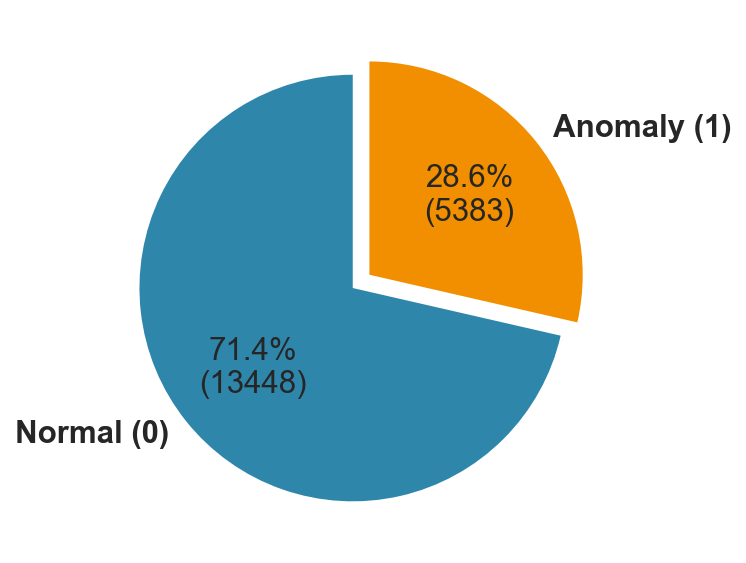

In [14]:
# Binary label distribution (pie)
plt.figure(figsize=(5, 5))
binary_counts = df_train_val['binary_label'].value_counts().sort_index()
colors_binary = ['#2E86AB', '#F18F01']
labels_binary = ['Normal (0)', 'Anomaly (1)']
wedges2, texts2, autotexts2 = plt.pie(binary_counts, labels=labels_binary, autopct=autopct_format(df_train_val['binary_label']),
            colors=colors_binary, startangle=90, explode=[0.05, 0.05],
            textprops={'fontsize': 15,  'fontweight': 'bold'})
for autotext in autotexts2:
    autotext.set_fontsize(15)
    autotext.set_fontweight('normal')

plt.tight_layout()
save_figure_for_report('task1_class_distribution_pie_binary.png')
plt.show()


In test.csv.

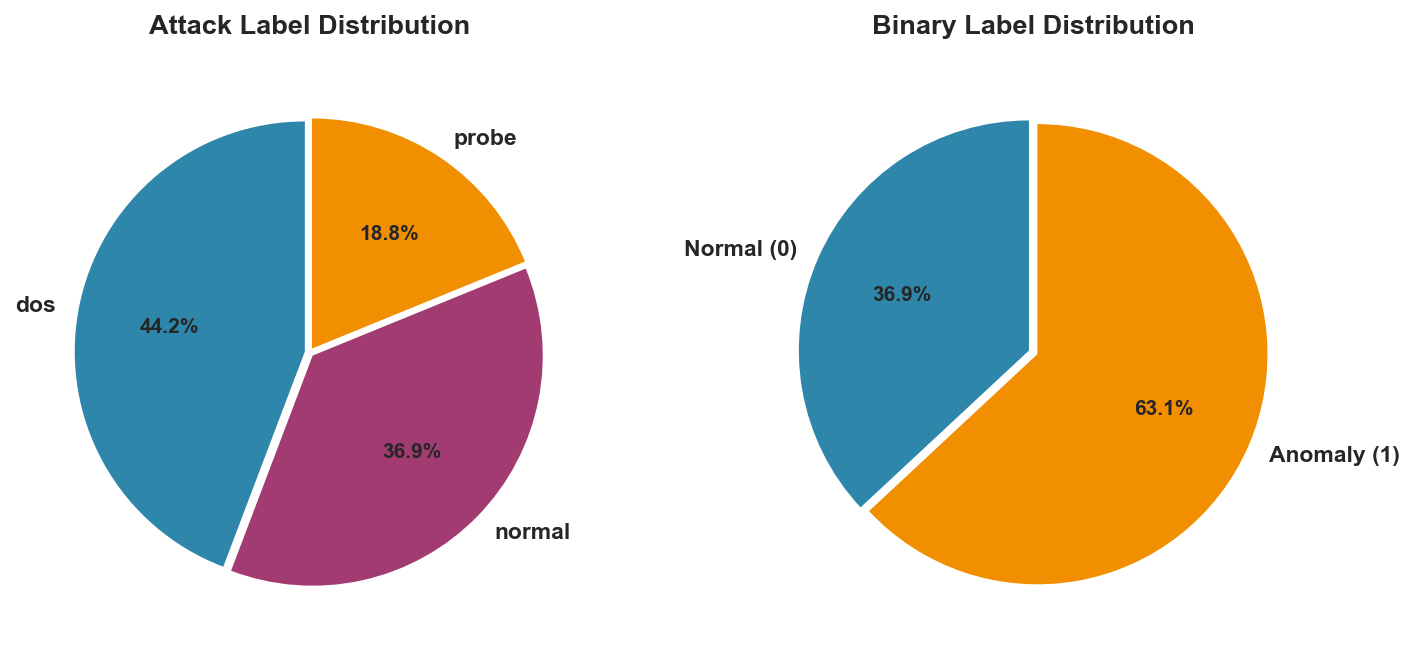


CLASS DISTRIBUTION SUMMARY

Binary Label Distribution:
  Normal:  2,152 (36.94%)
  Anomaly: 3,674 (63.06%)

Attack Label Distribution:
  dos: 2,577 (44.23%)
  normal: 2,152 (36.94%)
  probe: 1,097 (18.83%)


In [15]:
# Pie charts for class distribution - provides proportional view
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))

# Attack label distribution (pie)
attack_counts = df_test['label'].value_counts()
colors_attack = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
wedges1, texts1, autotexts1 = axes[0].pie(attack_counts, labels=attack_counts.index, autopct='%1.1f%%',
            colors=colors_attack, startangle=90, explode=[0.02]*len(attack_counts),
            textprops={'fontsize': 11, 'fontweight': 'bold'})
for autotext in autotexts1:
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')
axes[0].set_title('Attack Label Distribution', fontsize=13, fontweight='bold', pad=15)

# Binary label distribution (pie)
binary_counts = df_test['binary_label'].value_counts().sort_index()
colors_binary = ['#2E86AB', '#F18F01']
labels_binary = ['Normal (0)', 'Anomaly (1)']
wedges2, texts2, autotexts2 = axes[1].pie(binary_counts, labels=labels_binary, autopct='%1.1f%%',
            colors=colors_binary, startangle=90, explode=[0.02, 0.02],
            textprops={'fontsize': 11, 'fontweight': 'bold'})
for autotext in autotexts2:
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')
axes[1].set_title('Binary Label Distribution', fontsize=13, fontweight='bold', pad=15)

plt.tight_layout()
save_figure_for_report('task1_class_distribution_pie_test.png')
plt.show()

# Print exact percentages for reference
print("\n" + "="*60)
print("CLASS DISTRIBUTION SUMMARY")

print("="*60)
print("="*60)


print(f"\nBinary Label Distribution:")
print(f"  Normal:  {binary_counts[0]:,} ({binary_counts[0]/len(df_test)*100:.2f}%)")
print(f"  Anomaly: {binary_counts[1]:,} ({binary_counts[1]/len(df_test)*100:.2f}%)")

print("\nAttack Label Distribution:")
for label, count in attack_counts.items():
    print(f"  {label}: {count:,} ({count/len(df_test)*100:.2f}%)")


### Dataset Summary Statistics
Overview of the dataset dimensions and feature types, useful for the report's dataset characterization section.

In [129]:
# Comprehensive dataset summary
categorical_cols = ['protocol_type', 'service', 'flag']
label_cols = ['label', 'binary_label']
numerical_cols = [col for col in df_train_val.columns if col not in (categorical_cols + label_cols)]

print("="*70)
print("DATASET CHARACTERIZATION SUMMARY")
print("="*70)
print(f"\nDataset Dimensions:")
print(f"   • Training+Validation samples: {len(df_train_val):,}")
print(f"   • Test samples: {len(df_test):,}")
print(f"   • Total features: {len(df_train_val.columns) - 2}")  # Excluding labels

print(f"\nFeature Types:")
print(f"   • Categorical features: {len(categorical_cols)}")
for col in categorical_cols:
    n_unique = df_train_val[col].nunique()
    print(f"     - {col}: {n_unique} unique values")

print(f"   • Numerical features: {len(numerical_cols)}")
print(f"     (Including binary 0/1 features)")

print(f"\nLabel Information:")
print(f"   • Attack types: {df_train_val['label'].nunique()} ({', '.join(df_train_val['label'].unique())})")
print(f"   • Binary classes: 2 (Normal=0, Anomaly=1)")

# Imbalance ratio
normal_count = (df_train_val['binary_label'] == 0).sum()
anomaly_count = (df_train_val['binary_label'] == 1).sum()
imbalance_ratio = normal_count / anomaly_count if anomaly_count > 0 else float('inf')
print(f"\nClass Imbalance:")
print(f"   • Normal:Anomaly ratio = {imbalance_ratio:.2f}:1")
print("="*70)

DATASET CHARACTERIZATION SUMMARY

Dataset Dimensions:
   • Training+Validation samples: 18,831
   • Test samples: 5,826
   • Total features: 41

Feature Types:
   • Categorical features: 3
     - protocol_type: 3 unique values
     - service: 65 unique values
     - flag: 11 unique values
   • Numerical features: 38
     (Including binary 0/1 features)

Label Information:
   • Attack types: 4 (dos, probe, normal, r2l)
   • Binary classes: 2 (Normal=0, Anomaly=1)

Class Imbalance:
   • Normal:Anomaly ratio = 2.50:1


Figure saved to: ../Plots/Task1/task1_categorical_features_distribution.png


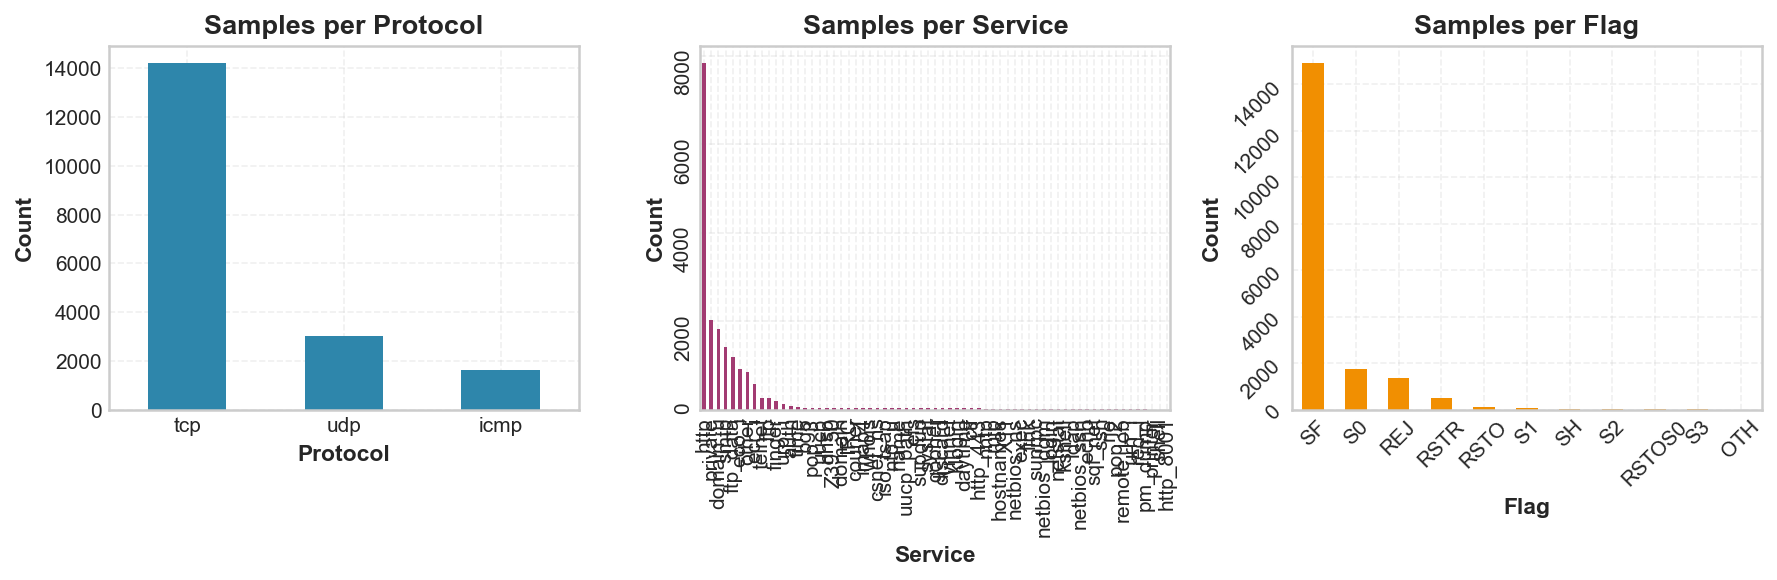

In [130]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Protocol type
df_train_val["protocol_type"].value_counts().plot(kind="bar", ax=axes[0], color='#2E86AB')
axes[0].set_title("Samples per Protocol")
axes[0].set_xlabel("Protocol")
axes[0].set_ylabel("Count")
axes[0].tick_params(rotation=0)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

# Service
df_train_val["service"].value_counts().plot(kind="bar", ax=axes[1], color='#A23B72')
axes[1].set_title("Samples per Service")
axes[1].set_xlabel("Service")
axes[1].set_ylabel("Count")
axes[1].tick_params(rotation=90)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

# Flag
df_train_val["flag"].value_counts().plot(kind="bar", ax=axes[2], color='#F18F01')
axes[2].set_title("Samples per Flag")
axes[2].set_xlabel("Flag")
axes[2].set_ylabel("Count")
axes[2].tick_params(rotation=45)
axes[2].grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
save_figure_for_report('task1_categorical_features_distribution.png')
plt.show()
plt.close()

Figure saved to: ../Plots/Task1/task1_categorical_features_distribution.png


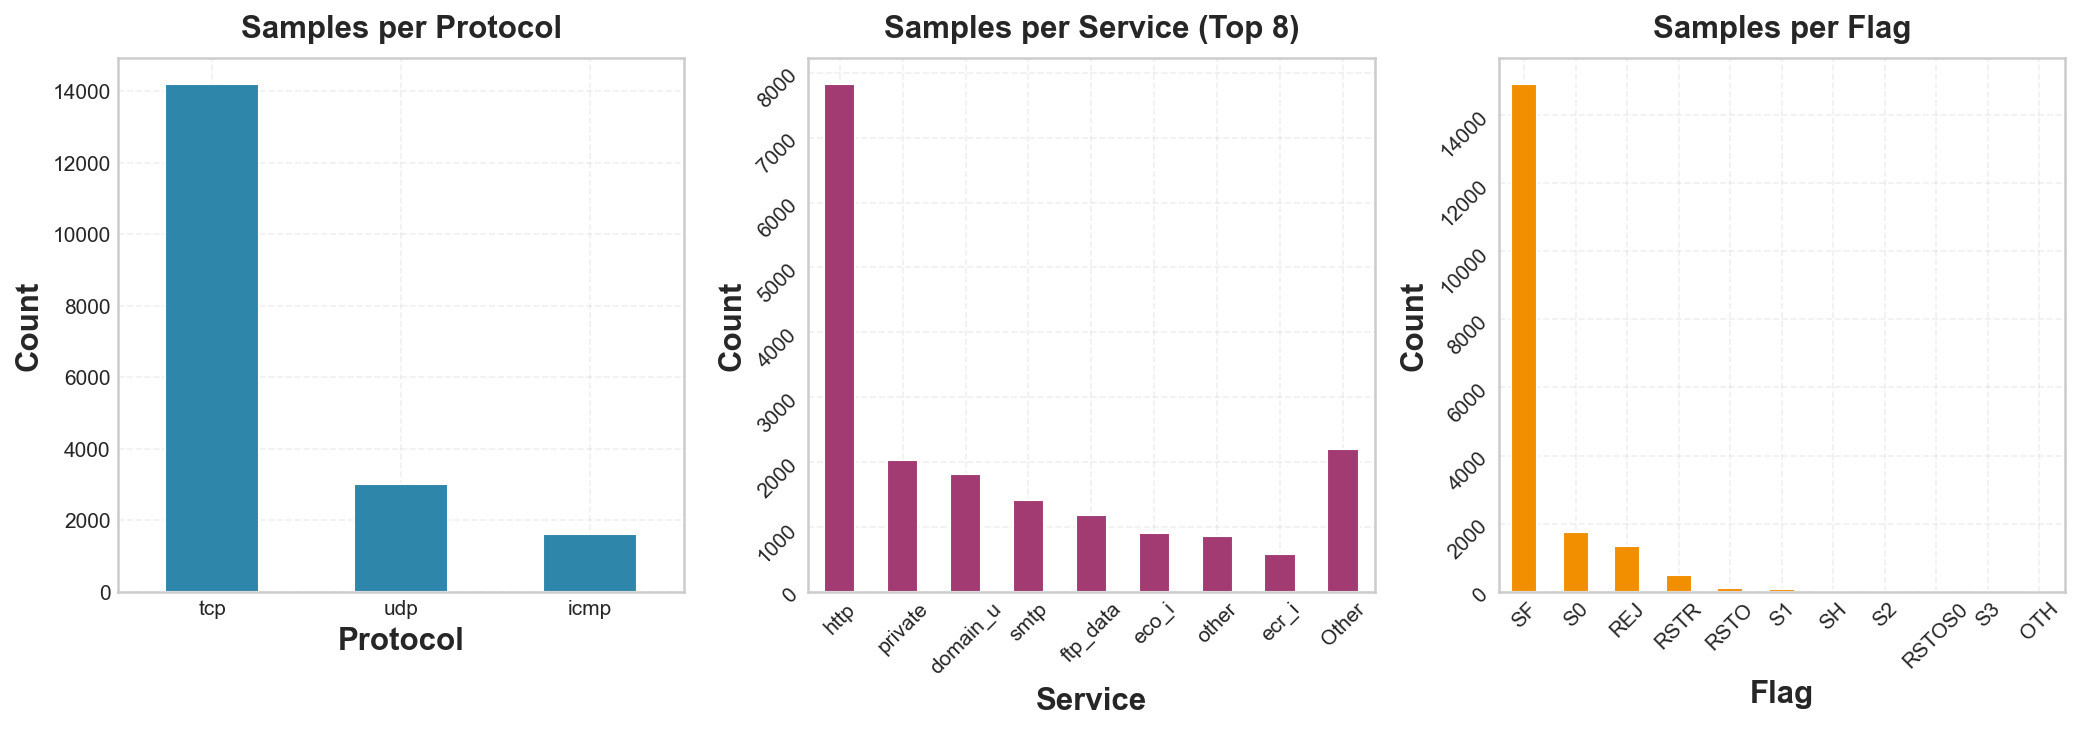

In [131]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# Protocol type
df_train_val["protocol_type"].value_counts().plot(kind="bar", ax=axes[0], color='#2E86AB', edgecolor='white')
axes[0].set_title("Samples per Protocol", fontsize=15, fontweight='bold', pad=10)
axes[0].set_xlabel("Protocol", fontsize=15, fontweight='bold')
axes[0].set_ylabel("Count", fontsize=15, fontweight='bold')
axes[0].tick_params(rotation=0, labelsize=10)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

# Service - Top 8 + Other for readability
TOP_N = 8
service_counts = df_train_val["service"].value_counts()
top_services = service_counts.head(TOP_N)
other_count = service_counts.iloc[TOP_N:].sum()
top_services_with_other = pd.concat([top_services, pd.Series({"Other": other_count})])
top_services_with_other.plot(kind="bar", ax=axes[1], color='#A23B72', edgecolor='white')
axes[1].set_title(f"Samples per Service (Top {TOP_N})", fontsize=15, fontweight='bold', pad=10)
axes[1].set_xlabel("Service", fontsize=15, fontweight='bold')
axes[1].set_ylabel("Count", fontsize=15, fontweight='bold')
axes[1].tick_params(rotation=45, labelsize=10)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

# Flag
df_train_val["flag"].value_counts().plot(kind="bar", ax=axes[2], color='#F18F01', edgecolor='white')
axes[2].set_title("Samples per Flag", fontsize=15, fontweight='bold', pad=10)
axes[2].set_xlabel("Flag", fontsize=15, fontweight='bold')
axes[2].set_ylabel("Count", fontsize=15, fontweight='bold')
axes[2].tick_params(rotation=45, labelsize=10)
axes[2].grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
save_figure_for_report('task1_categorical_features_distribution.png')
plt.show()
plt.close()

Now, we visualize the distribution of the values of numerical features.

In [132]:
data_visual = df_train_val.drop(['label','flag','protocol_type','service','binary_label'], axis=1)

/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/pandas/core/nanops.py:1016: Runtime

Figure saved to: ../Plots/Task1/task1_feature_distributions_logscale.png


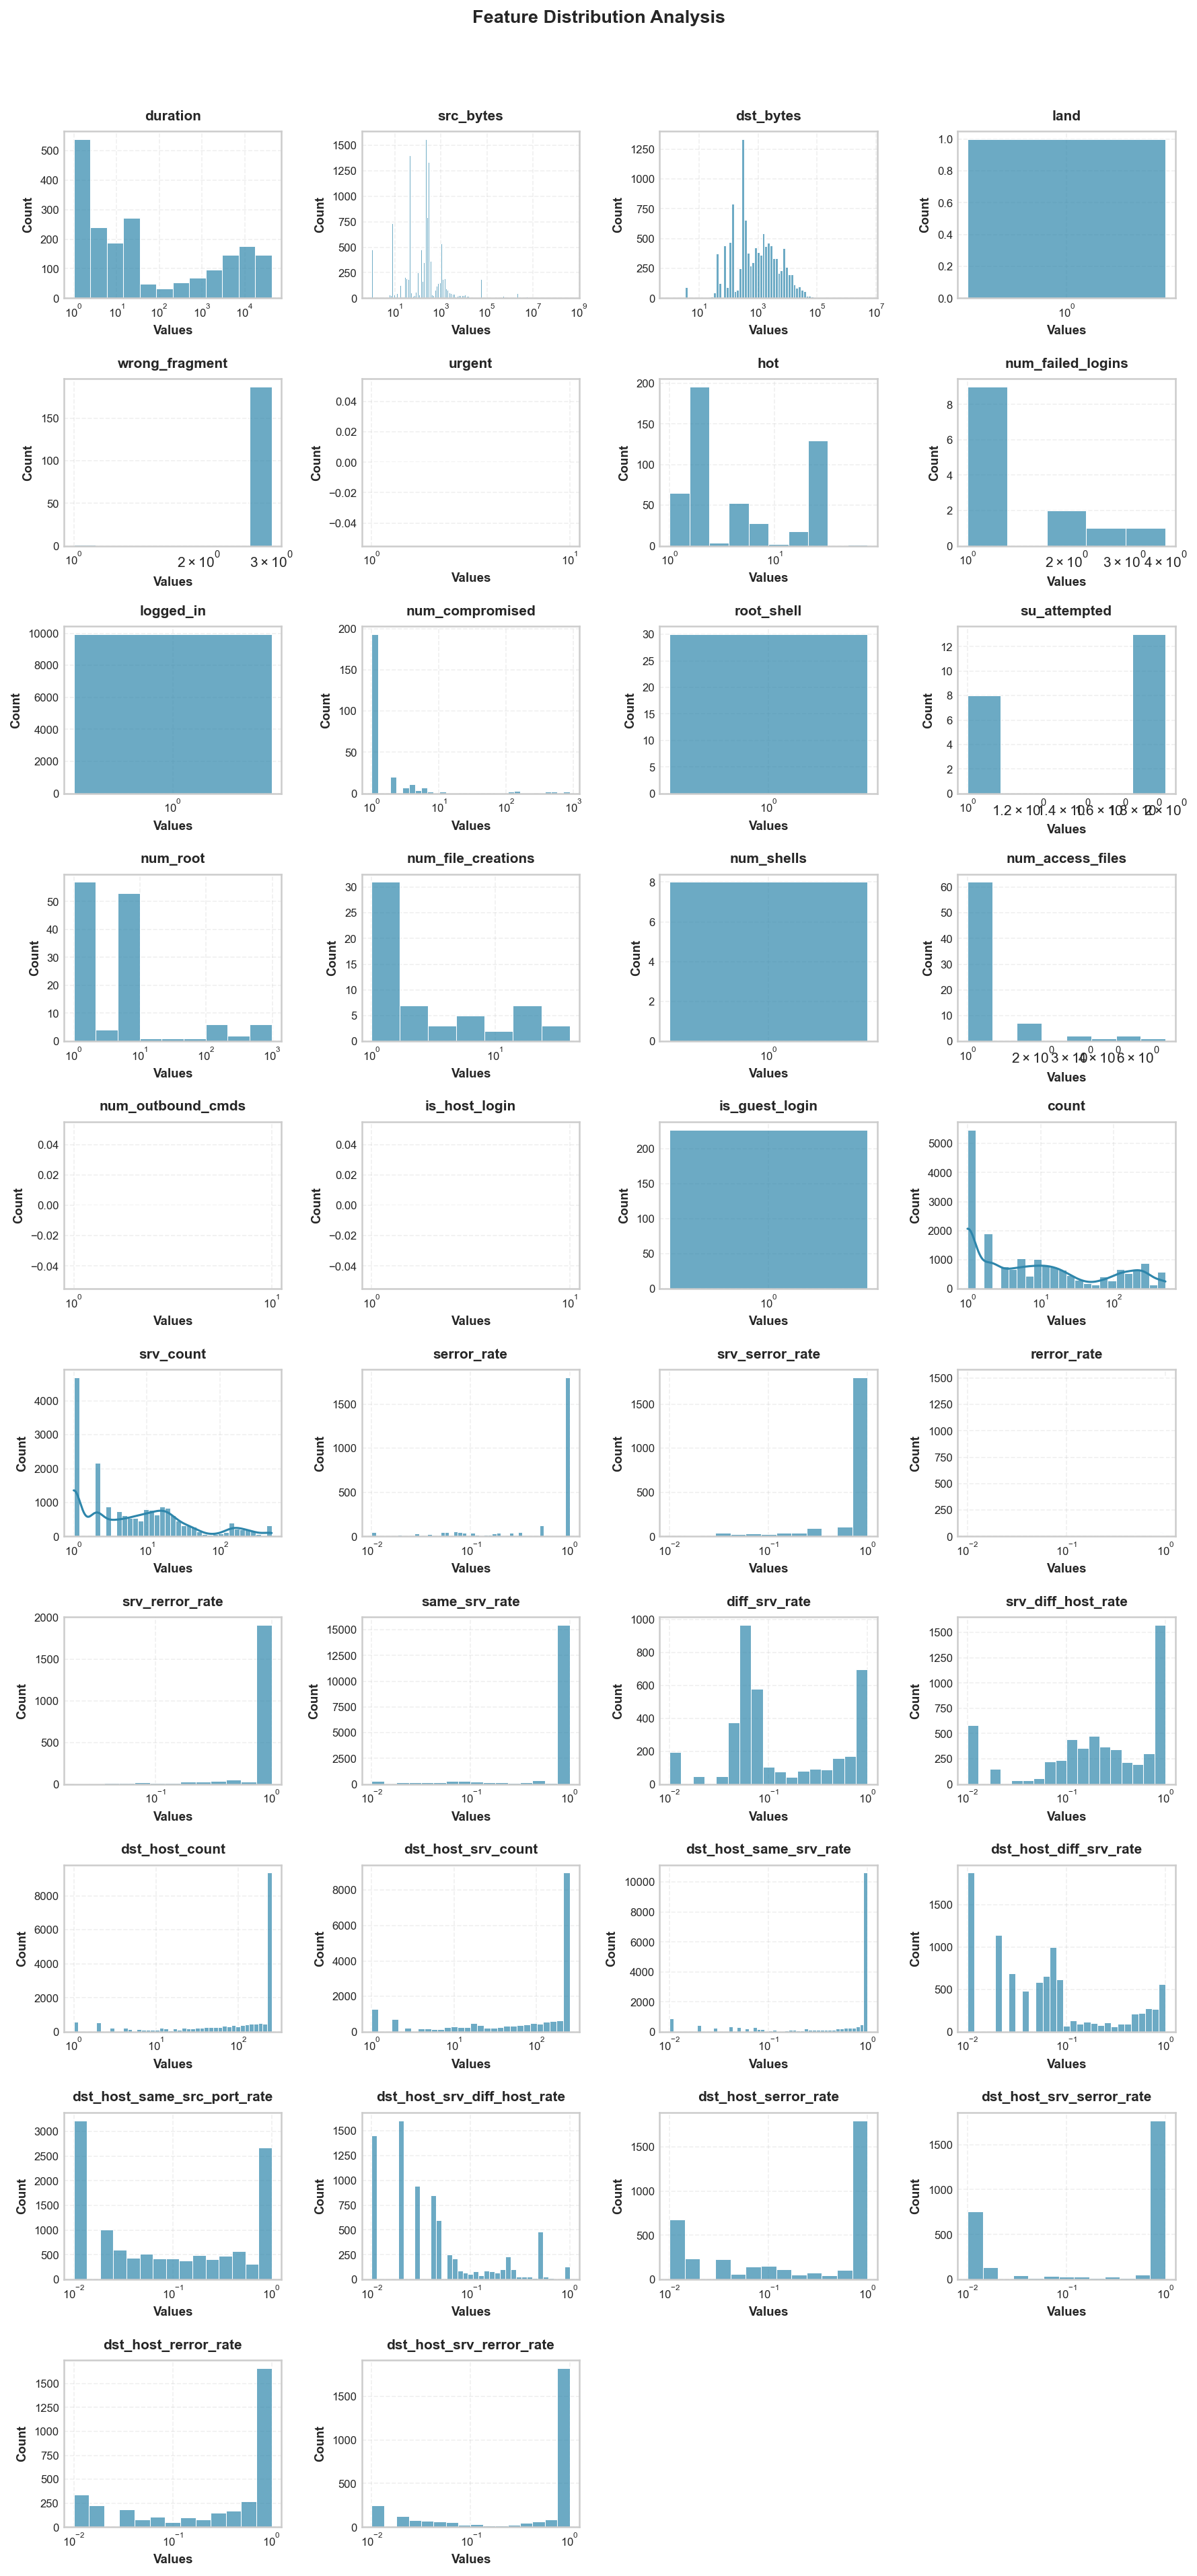


OUTLIER ANALYSIS SUMMARY
Long tails indicate presence of outliers (e.g., packet/byte counts)
Standardization (StandardScaler) will address these outliers


In [133]:
features = data_visual.columns

# Create a grid of subplots (4 rows x 4 columns for 16 features)
n_features = len(features)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 2.5))
axes = axes.flatten()  # Flatten to easily iterate

for idx, feature in enumerate(features):
    ax = axes[idx]

    # Create histogram with KDE
    sns.histplot(data=data_visual, x=feature, kde=True, color='#2E86AB',
                 ax=ax, log_scale=True, alpha=0.7, edgecolor='white', linewidth=0.5)

    # Styling
    ax.set_title(feature, fontsize=10, fontweight='bold', pad=8)
    ax.set_xlabel('Values', fontsize=9)
    ax.set_ylabel('Count', fontsize=9)
    ax.tick_params(labelsize=8)
    ax.grid(axis='y', alpha=0.3, linestyle='--')

# Hide any unused subplots
for idx in range(n_features, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Feature Distribution Analysis',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
save_figure_for_report('task1_feature_distributions_logscale.png')
plt.show()

print("\n" + "="*70)
print("OUTLIER ANALYSIS SUMMARY")
print("="*70)
print("Long tails indicate presence of outliers (e.g., packet/byte counts)")
print("Standardization (StandardScaler) will address these outliers")
print("="*70)

### Feature Correlation Analysis
The correlation matrix reveals relationships between numerical features. High correlations (positive or negative) indicate redundant features that carry similar information. This is important for:
1. Understanding feature dependencies
2. Identifying potential multicollinearity issues
3. Informing feature selection strategies

Figure saved to: ../Plots/Task1/task1_correlation_matrix.png


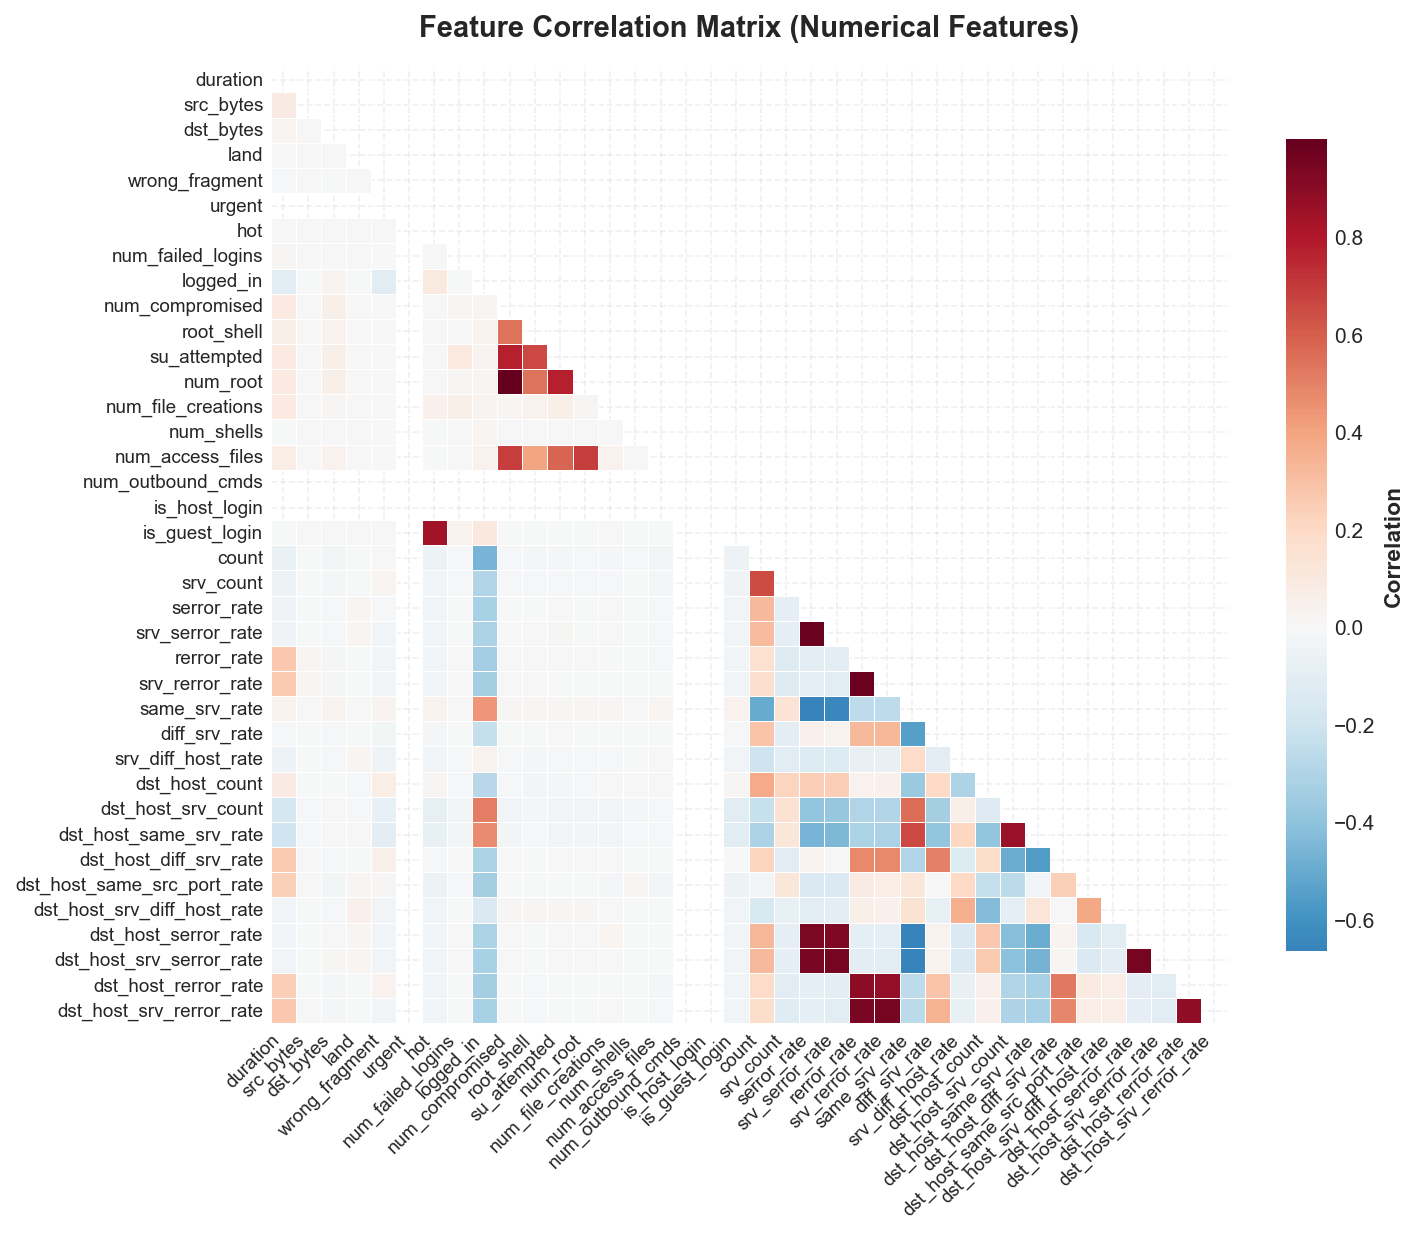


HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.8)
  num_compromised ↔ num_root: r = 0.999
  rerror_rate ↔ srv_rerror_rate: r = 0.984
  serror_rate ↔ srv_serror_rate: r = 0.981
  dst_host_serror_rate ↔ dst_host_srv_serror_rate: r = 0.959
  srv_serror_rate ↔ dst_host_srv_serror_rate: r = 0.958
  srv_rerror_rate ↔ dst_host_srv_rerror_rate: r = 0.954
  rerror_rate ↔ dst_host_srv_rerror_rate: r = 0.946
  serror_rate ↔ dst_host_srv_serror_rate: r = 0.943
  serror_rate ↔ dst_host_serror_rate: r = 0.935
  srv_serror_rate ↔ dst_host_serror_rate: r = 0.930
  rerror_rate ↔ dst_host_rerror_rate: r = 0.889
  dst_host_rerror_rate ↔ dst_host_srv_rerror_rate: r = 0.883
  srv_rerror_rate ↔ dst_host_rerror_rate: r = 0.876
  dst_host_srv_count ↔ dst_host_same_srv_rate: r = 0.857
  hot ↔ is_guest_login: r = 0.837


In [134]:
# Correlation matrix for numerical features
numerical_data = df_train_val.drop(['label', 'binary_label', 'protocol_type', 'service', 'flag'], axis=1)
correlation_matrix = numerical_data.corr()

plt.figure(figsize=(10, 9))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Upper triangle mask
sns.heatmap(correlation_matrix, mask=mask, cmap='RdBu_r', center=0,
            annot=False, square=True, linewidths=0.3,
            cbar_kws={"shrink": 0.7, "label": "Correlation"},
            xticklabels=True, yticklabels=True)
plt.title('Feature Correlation Matrix (Numerical Features)', fontsize=14, fontweight='bold', pad=15)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
save_figure_for_report('task1_correlation_matrix.png')
plt.show()

# Find highly correlated feature pairs
threshold = 0.8
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

if high_corr_pairs:
    print("\n" + "="*70)
    print(f"HIGHLY CORRELATED FEATURE PAIRS (|r| > {threshold})")
    print("="*70)
    for f1, f2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        print(f"  {f1} ↔ {f2}: r = {corr:.3f}")
    print("="*70)
else:
    print(f"\nNo feature pairs with correlation > {threshold}")

### Attack Distribution by Protocol Type
Now we visualize which protocols are targeted by each attack type, that is crucial for IDS rule development. This visualization shows the relationship between categorical features and attack labels.

Figure saved to: ../Plots/Task1/task1_attack_by_categorical.png


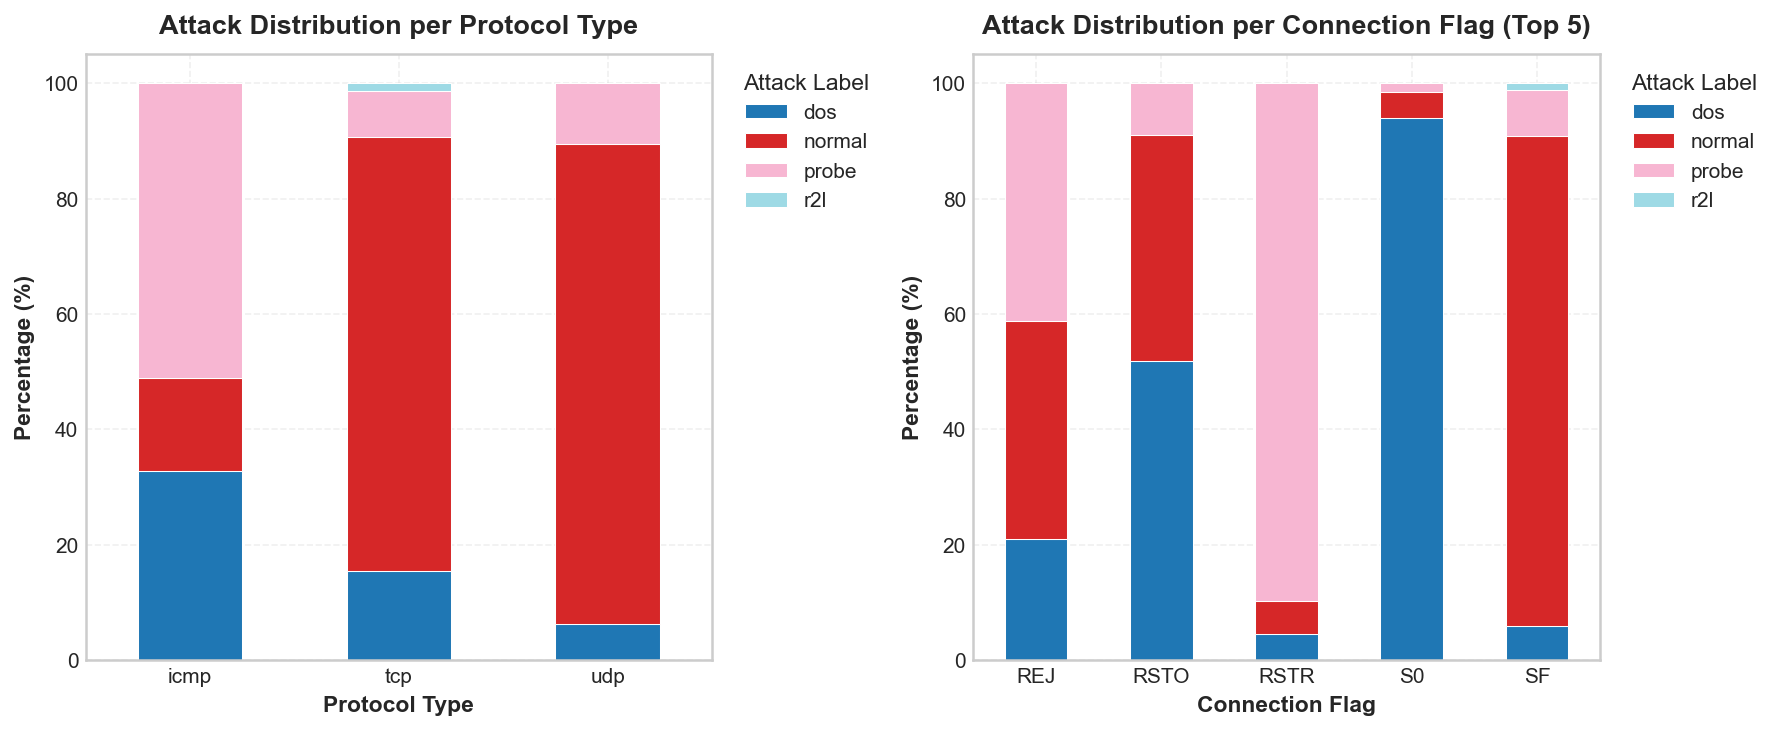


CATEGORICAL FEATURE INSIGHTS
Protocol Analysis:
   • Different protocols are targeted by different attack types
   • TCP is commonly used for most connection-based attacks
   • ICMP may show probe-related patterns

Connection Flag Analysis:
   • SF (normal finish) is typical for normal connections
   • S0, REJ flags may indicate scanning or DoS attempts


In [135]:
# Cross-tabulation: Protocol Type vs Attack Label
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Protocol Type vs Attack Label (stacked bar)
protocol_attack = pd.crosstab(df_train_val['protocol_type'], df_train_val['label'], normalize='index') * 100
protocol_attack.plot(kind='bar', stacked=True, ax=axes[0], colormap='tab20', edgecolor='white', linewidth=0.5)
axes[0].set_title('Attack Distribution per Protocol Type', fontsize=13, fontweight='bold', pad=10)
axes[0].set_xlabel('Protocol Type', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Percentage (%)', fontsize=11, fontweight='bold')
axes[0].legend(title='Attack Label', fontsize=10, title_fontsize=11, bbox_to_anchor=(1.02, 1), loc='upper left')
axes[0].tick_params(rotation=0, labelsize=10)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

# Flag vs Attack Label (stacked bar) - top 5 flags
top_flags = df_train_val['flag'].value_counts().head(5).index
df_top_flags = df_train_val[df_train_val['flag'].isin(top_flags)]
flag_attack = pd.crosstab(df_top_flags['flag'], df_top_flags['label'], normalize='index') * 100
flag_attack.plot(kind='bar', stacked=True, ax=axes[1], colormap='tab20', edgecolor='white', linewidth=0.5)
axes[1].set_title('Attack Distribution per Connection Flag (Top 5)', fontsize=13, fontweight='bold', pad=10)
axes[1].set_xlabel('Connection Flag', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Percentage (%)', fontsize=11, fontweight='bold')
axes[1].legend(title='Attack Label', fontsize=10, title_fontsize=11, bbox_to_anchor=(1.02, 1), loc='upper left')
axes[1].tick_params(rotation=0, labelsize=10)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
save_figure_for_report('task1_attack_by_categorical.png')
plt.show()

print("\n" + "="*70)
print("CATEGORICAL FEATURE INSIGHTS")
print("="*70)
print("Protocol Analysis:")
print("   • Different protocols are targeted by different attack types")
print("   • TCP is commonly used for most connection-based attacks")
print("   • ICMP may show probe-related patterns")
print("\nConnection Flag Analysis:")
print("   • SF (normal finish) is typical for normal connections")
print("   • S0, REJ flags may indicate scanning or DoS attempts")
print("="*70)

### Question 1: Dataset Characterization
**Q: What are the dataset characteristics? How many categorical and numerical attributes do you have? How are your attack labels and binary label distributed?**

**Answer:**
Based on the exploration above:
- The dataset consists of network traffic data with various features.
- **Categorical Attributes:** There are 3 main categorical attributes: `protocol_type`, `service`, and `flag`.
- **Numerical Attributes:** The remaining attributes are numerical (e.g., `duration`, `src_bytes`, `dst_bytes`, counts, rates).
- **Label Distribution:** The `label` distribution plot shows the counts for 'normal', 'dos', 'probe', and 'r2l'. The `binary_label` plot shows the balance between normal (0) and anomalous (1) traffic. The dataset appears to have a significant number of normal samples compared to specific attack types, but the binary distribution gives a clearer view of the overall anomaly ratio.

## Preprocessing

First, we check if in the dataset there are infinite, NaN or duplicate values.

In [136]:
# check for the infinite values
print(df_train_val.isin([np.inf, -np.inf]).sum())

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [137]:
# Checking null values
print(df_train_val.isnull().sum())

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [138]:
# Remove duplicates
print("Number of rows before duplicates", df_train_val.shape[0])
data = df_train_val.drop_duplicates()
print("Number of rows after removing duplicates", data.shape[0])

# Remove rows with missing values
data = data.dropna()
print("Number of rows after missing values", data.shape[0])

# Now drop the instances with inifinite values
data = data.replace([np.inf, -np.inf], np.nan).dropna()
print("Number of rows after removing infinite values", data.shape[0])

# Remove duplicates
print("Test set")
print("Number of rows before duplicates", df_test.shape[0])
data_test = df_test.drop_duplicates()
print("Number of rows after removing duplicates", data_test.shape[0])

# Remove rows with missing values
data_test = data_test.dropna()
print("Number of rows after missing values", data_test.shape[0])

# Now drop the instances with inifinite values
data_test = data_test.replace([np.inf, -np.inf], np.nan).dropna()
print("Number of rows after removing infinite values", data_test.shape[0])

# Encode labels
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])
data_test['label'] = label_encoder.transform(data_test['label'])

Number of rows before duplicates 18831
Number of rows after removing duplicates 18831
Number of rows after missing values 18831
Number of rows after removing infinite values 18831
Test set
Number of rows before duplicates 5826
Number of rows after removing duplicates 5826
Number of rows after missing values 5826
Number of rows after removing infinite values 5826


In [139]:
label_encoder.classes_

array(['dos', 'normal', 'probe', 'r2l'], dtype=object)

In [140]:
preprocessed_train = data.drop(['urgent','num_outbound_cmds','is_host_login'], axis=1)

df_test = df_test.drop(['urgent','num_outbound_cmds','is_host_login'], axis=1)

Split into train and validation sets.

In [141]:
df_train, df_val = train_test_split(preprocessed_train, train_size=0.9, stratify=preprocessed_train["label"],random_state=42)

In [142]:
df_train['flag'].value_counts()

flag
SF        13403
S0         1593
REJ        1222
RSTR        462
RSTO         97
S1           76
SH           36
RSTOS0       20
S2           18
S3           15
OTH           5
Name: count, dtype: int64

In [143]:
df_train['service'].value_counts()[0:15]

service
http        7053
private     1832
domain_u    1621
smtp        1286
ftp_data    1063
eco_i        822
other        758
ecr_i        506
ftp          246
telnet       239
finger       174
urp_i        116
auth          66
time          52
uucp          41
Name: count, dtype: int64

In [144]:
df_train['protocol_type'].value_counts()

protocol_type
tcp     12832
udp      2666
icmp     1449
Name: count, dtype: int64

Now we start encoding the categorical features: we keep the most used values and we aggregate the others into the `other` category. 

In [145]:
# Define the allowed list of services
allowed_services = ["http", "private", "smtp", "domain_u", "other", "ftp_data", "ecr_i", "eco_i"]

# Apply the mapping WARNING we increase the diversity in in the "other" class
df_train["service"] = df_train["service"].apply(lambda x: x if x in allowed_services else "other")
df_val["service"] = df_val["service"].apply(lambda x: x if x in allowed_services else "other")
df_test["service"] = df_test["service"].apply(lambda x: x if x in allowed_services else "other")

In [146]:
# Define the allowed list of services
allowed_flag = ["SF", "S0", "REJ","RSTR","RSTO"]

# Apply the mapping
df_train["flag"] = df_train["flag"].apply(lambda x: x if x in allowed_flag else "other")
df_val["flag"] = df_val["flag"].apply(lambda x: x if x in allowed_flag else "other")
df_test["flag"] = df_test["flag"].apply(lambda x: x if x in allowed_flag else "other")

Now we perform feature standardization and process categorical and numerical features simultaneously: the numerical features are standardized, while the categorical ones encoded using one hot encoding.

In [ ]:
# === 1. Set up column groups ===
ignore_cols = ['label', 'binary_label']  # columns to skip entirely
categorical_cols = ['protocol_type', 'service', 'flag']
numerical_cols = [col for col in df_train.columns if col not in categorical_cols + ignore_cols]

# === 2. Define ColumnTransformer ===
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='drop'  # drop columns not listed (i.e., ignore_cols)
)

# === 3. Fit on training, transform all splits ===
X_train_transformed = preprocessor.fit_transform(df_train)
X_val_transformed   = preprocessor.transform(df_val)
X_test_transformed  = preprocessor.transform(df_test)

# === 4. Get transformed feature names and make DataFrames ===
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = list(numerical_cols) + list(cat_feature_names)

df_train_preprocessed = pd.DataFrame(X_train_transformed, columns=all_feature_names)
df_val_preprocessed   = pd.DataFrame(X_val_transformed, columns=all_feature_names)
df_test_preprocessed  = pd.DataFrame(X_test_transformed, columns=all_feature_names)

# === 5. Restore the labels ===
df_train_preprocessed["label"] = list(df_train["label"])
df_val_preprocessed["label"]   = list(df_val["label"])
df_test_preprocessed["label"]  = list(df_test["label"])

df_train_preprocessed["binary_label"] = list(df_train["binary_label"])
df_val_preprocessed["binary_label"]   = list(df_val["binary_label"])
df_test_preprocessed["binary_label"]  = list(df_test["binary_label"])

In [ ]:
df_train_preprocessed.shape

(16947, 54)

### Question 2: Preprocessing
**Q: How do you preprocess categorical and numerical data?**

**Answer:**
The preprocessing steps implemented are:
1.  **Cleaning:** Duplicates and rows with missing or infinite values were removed.
2.  **Categorical Data:** We used `OneHotEncoder` to transform categorical features (`protocol_type`, `service`, `flag`) into numerical representations. We also grouped less frequent categories into an "other" category for `service` and `flag` to reduce dimensionality.
3.  **Numerical Data:** We used `StandardScaler` to normalize numerical features, ensuring they have a mean of 0 and a standard deviation of 1. This is crucial for algorithms sensitive to feature scales.

In [148]:
def plot_heatmap(df, title_suffix, filename):
    plt.figure(figsize=(10, 12))
    sns.heatmap(df.T, cmap="Blues", annot=True, fmt='.2f', annot_kws={'size': 7},
                cbar_kws={"label": "Value"}, xticklabels=label_encoder.classes_)
    plt.title(f"{title_suffix} per Attack Label", fontsize=13, fontweight='bold', pad=15)
    plt.xlabel("Attack Label")
    plt.ylabel("Features")
    plt.tick_params(labelsize=9)
    plt.tight_layout()
    save_figure_for_report(filename)
    plt.show()

### Heatmaps
#### Mean heatmap

Figure saved to: ../Plots/Task1/task1_heatmap_mean.png


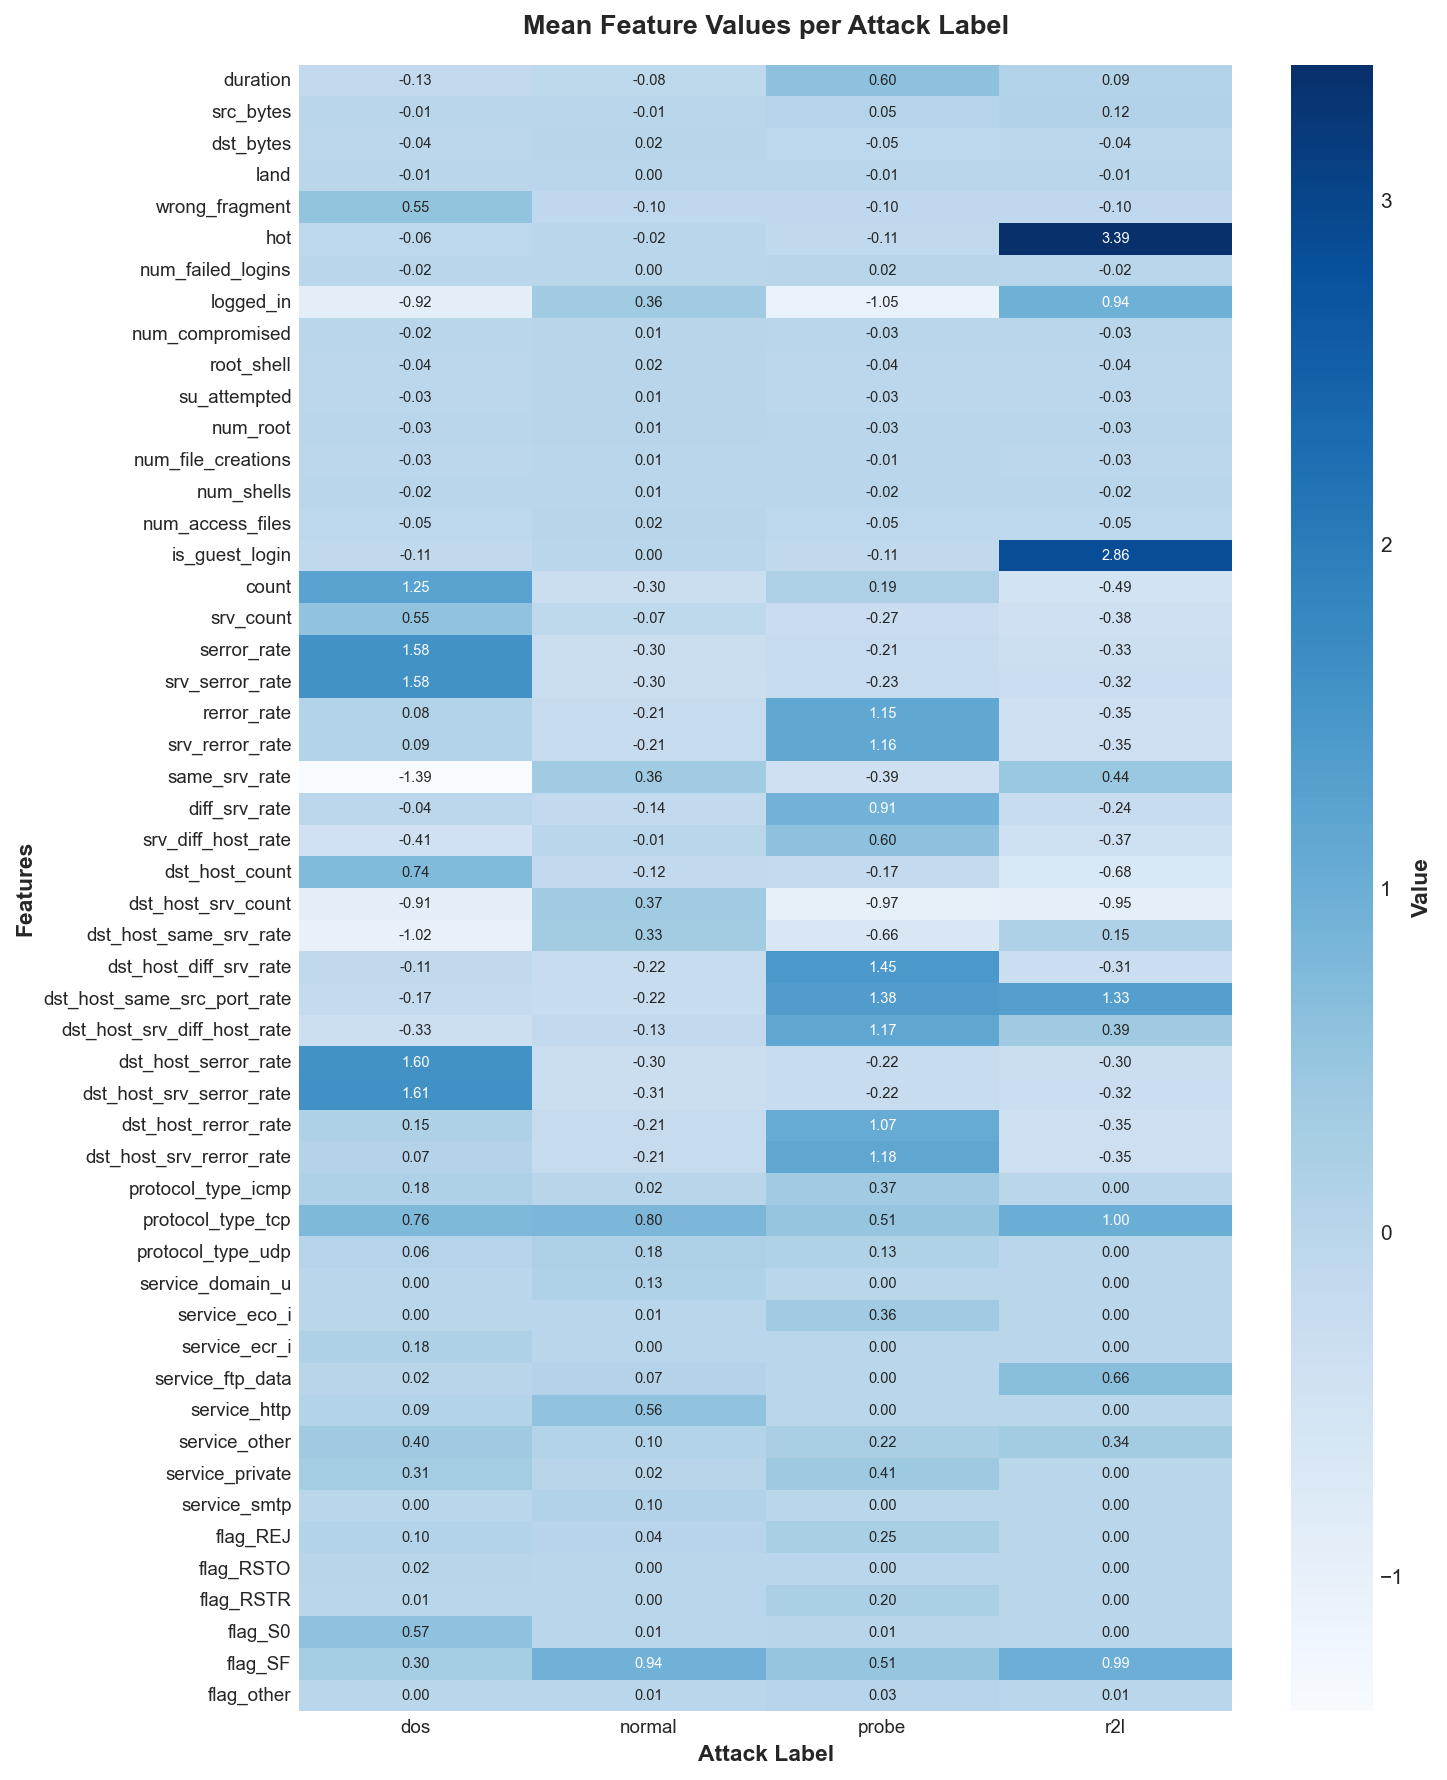

In [149]:
feature_cols = [col for col in df_train_preprocessed.columns if col not in ["label", "binary_label"]]
label_feature_means = df_train_preprocessed.groupby("label")[feature_cols].mean()

plot_heatmap(label_feature_means, "Mean Feature Values", "task1_heatmap_mean.png")

#### Standard Deviation heatmap

Figure saved to: ../Plots/Task1/task1_heatmap_std.png


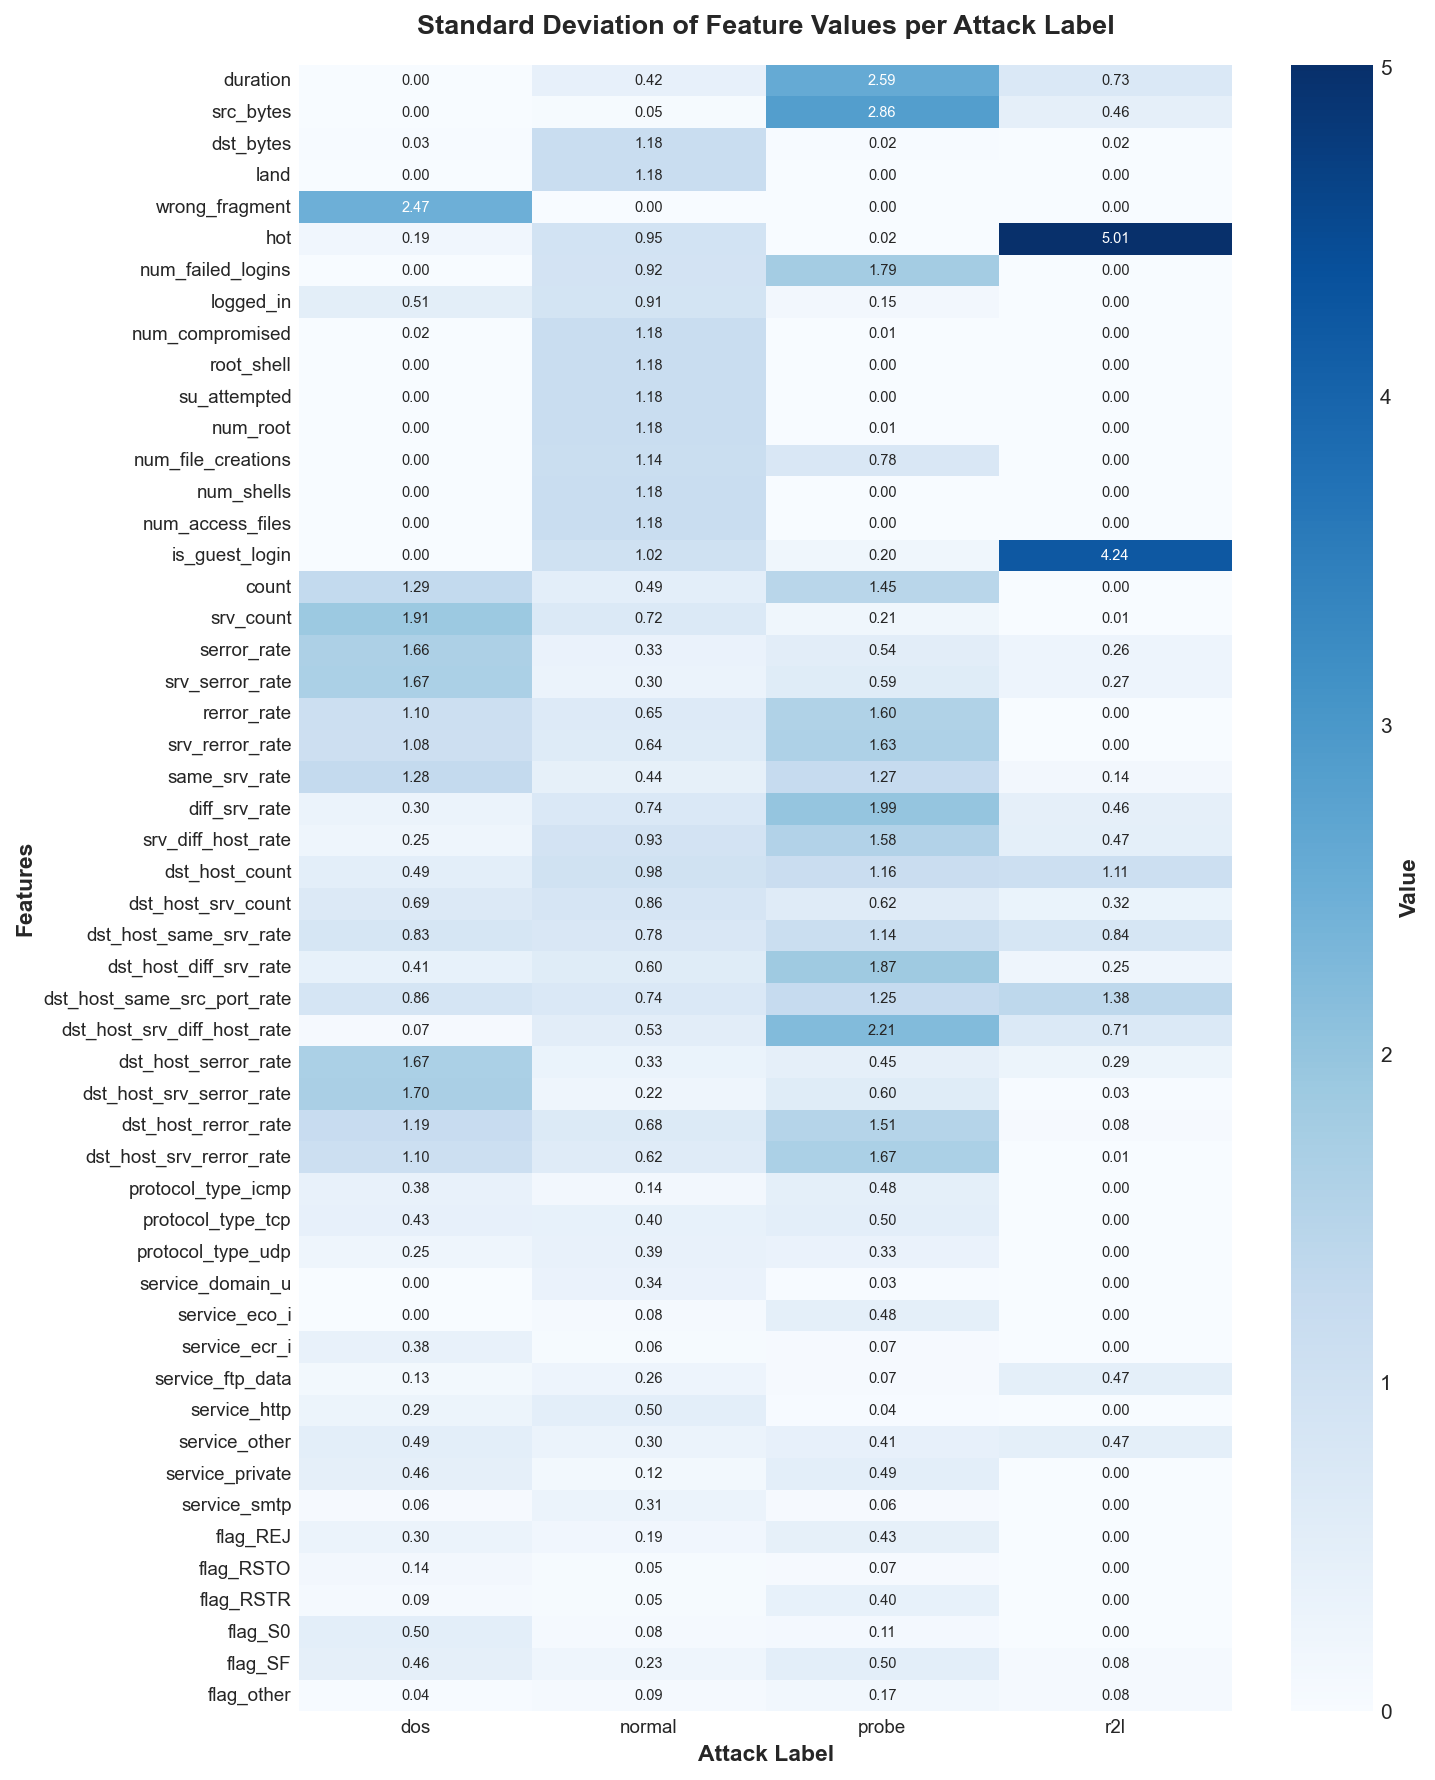

In [150]:
label_feature_std = df_train_preprocessed.groupby("label")[feature_cols].std()

plot_heatmap(label_feature_std, "Standard Deviation of Feature Values", "task1_heatmap_std.png")

#### Median Heatmap

Figure saved to: ../Plots/Task1/task1_heatmap_median.png


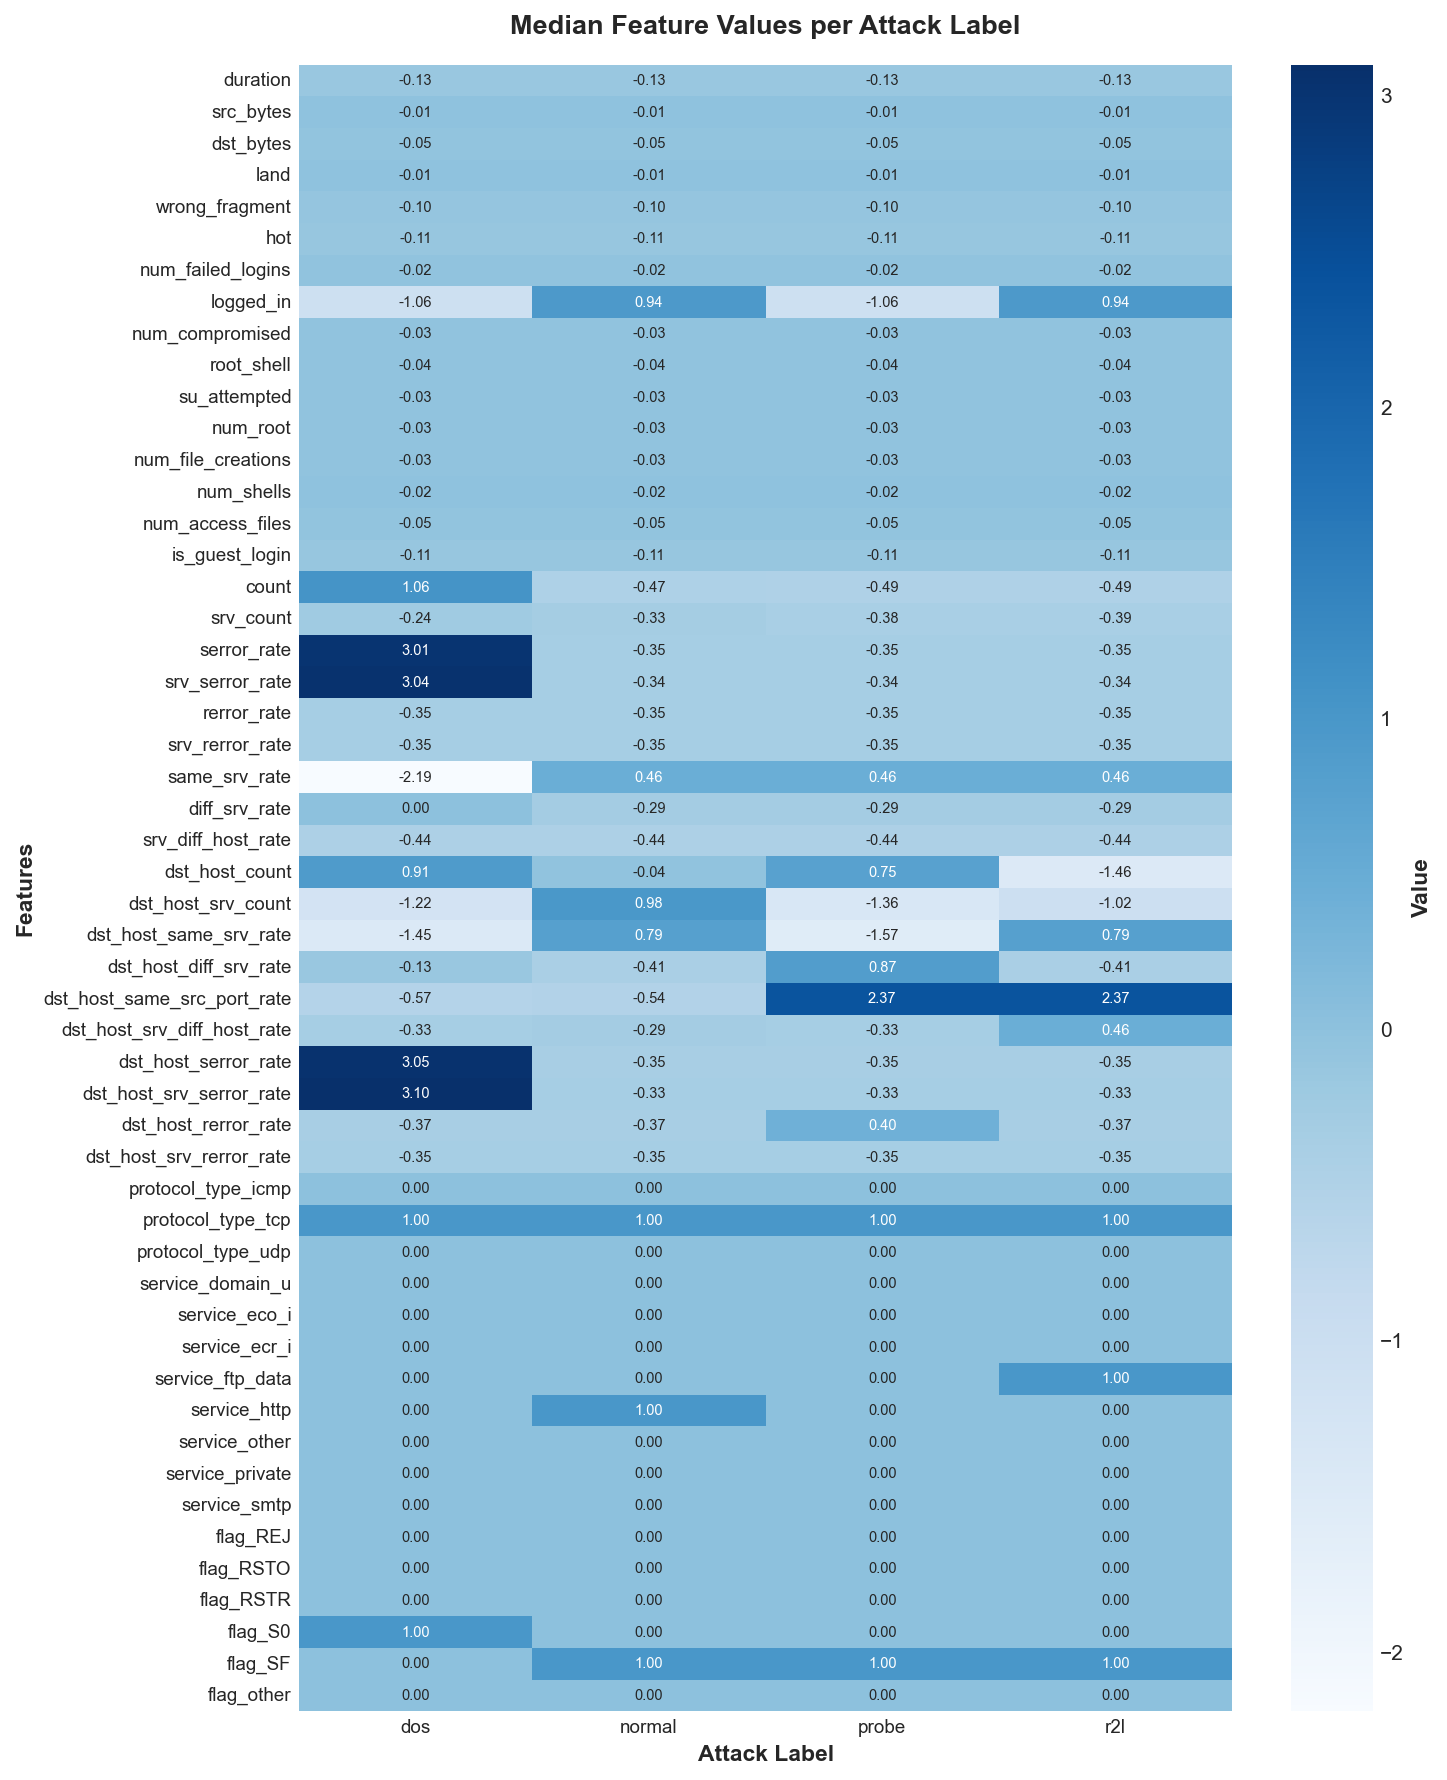

In [151]:
label_feature_median = df_train_preprocessed.groupby("label")[feature_cols].median()

plot_heatmap(label_feature_median, "Median Feature Values", "task1_heatmap_median.png")

Figure saved to: ../Plots/Task1/task1_heatmaps_combined_complete.png


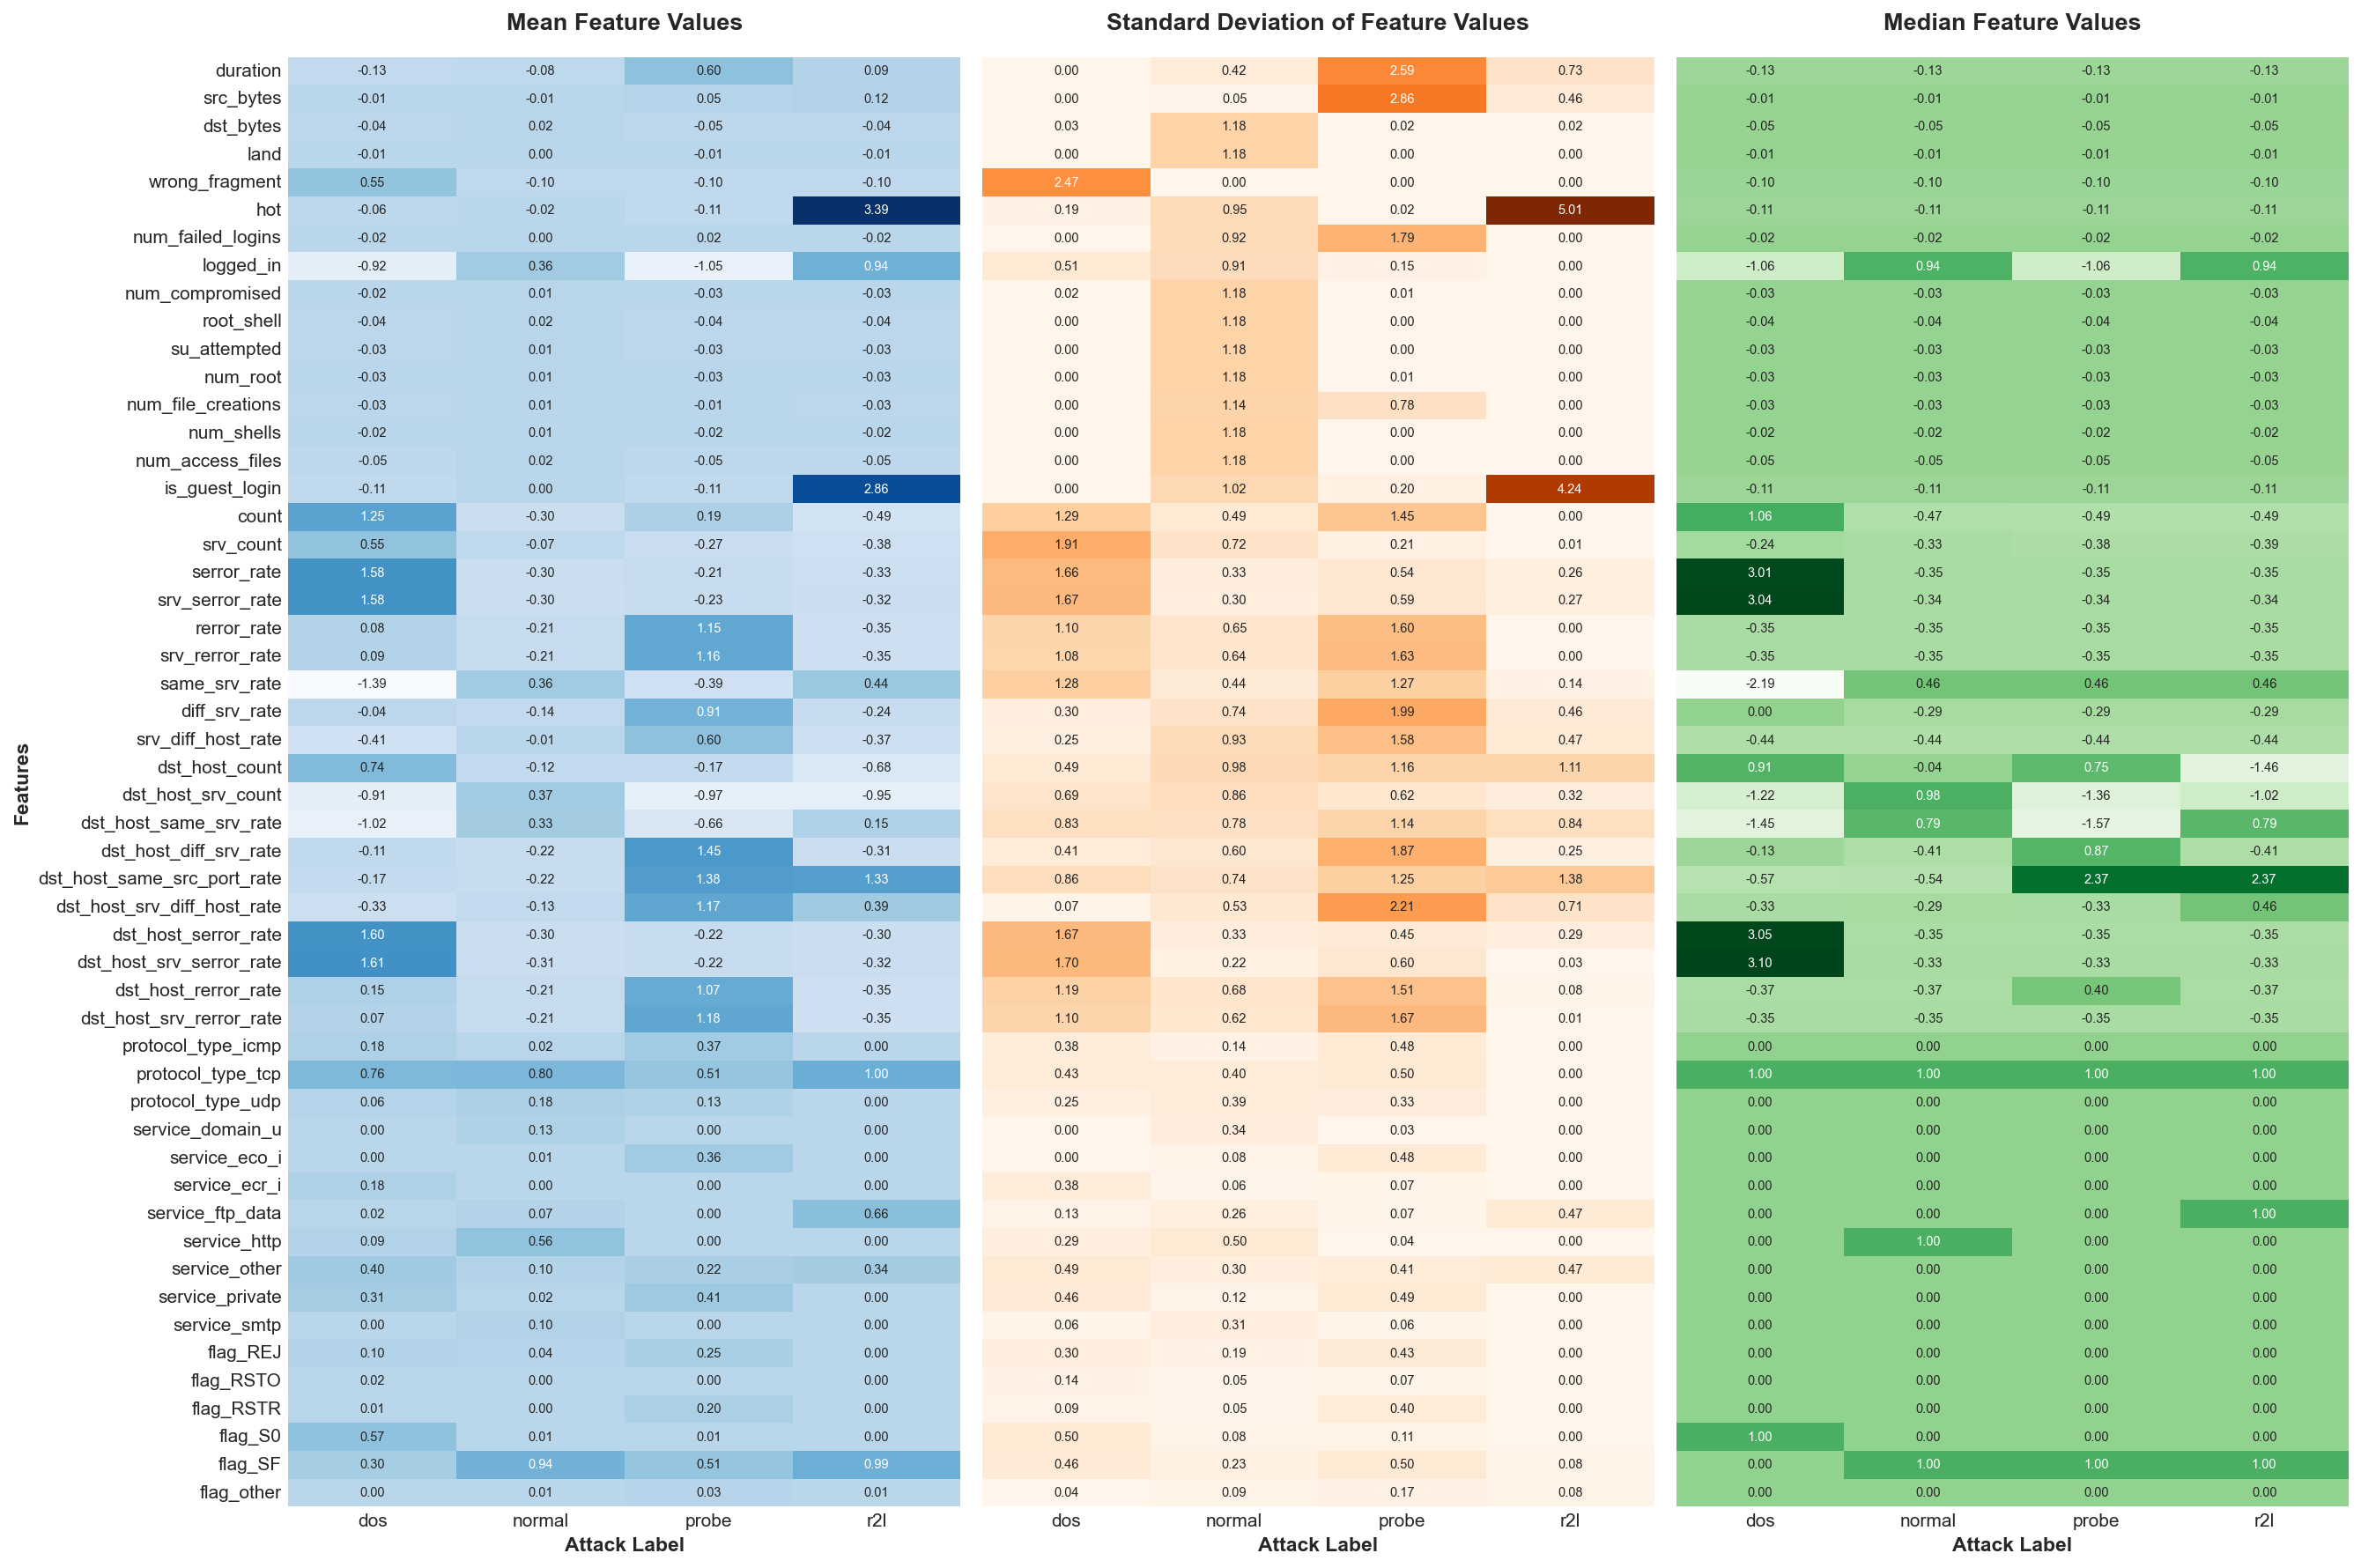

In [188]:
# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 12), sharey=True)

# Mean heatmap
sns.heatmap(label_feature_means.T, cmap="Blues", annot=True, fmt='.2f',
            annot_kws={'size': 7}, cbar=False,
            xticklabels=label_encoder.classes_, ax=axes[0])
axes[0].set_title("Mean Feature Values", fontsize=13, fontweight='bold', pad=15)
axes[0].set_xlabel("Attack Label", fontsize=11, fontweight='bold')
axes[0].set_ylabel("Features", fontsize=11, fontweight='bold')

# Standard Deviation heatmap
sns.heatmap(label_feature_std.T, cmap="Oranges", annot=True, fmt='.2f',
            annot_kws={'size': 7}, cbar=False,
            xticklabels=label_encoder.classes_, ax=axes[1])
axes[1].set_title("Standard Deviation of Feature Values", fontsize=13, fontweight='bold', pad=15)
axes[1].set_xlabel("Attack Label", fontsize=11, fontweight='bold')

# Median heatmap
sns.heatmap(label_feature_median.T, cmap="Greens", annot=True, fmt='.2f',
            annot_kws={'size': 7}, cbar=False,
            xticklabels=label_encoder.classes_, ax=axes[2])
axes[2].set_title("Median Feature Values", fontsize=13, fontweight='bold', pad=15)
axes[2].set_xlabel("Attack Label", fontsize=11, fontweight='bold')

plt.tight_layout()
save_figure_for_report('task1_heatmaps_combined_complete.png')
plt.show()

Figure saved to: ../Plots/Task1/task1_heatmaps_combined.png


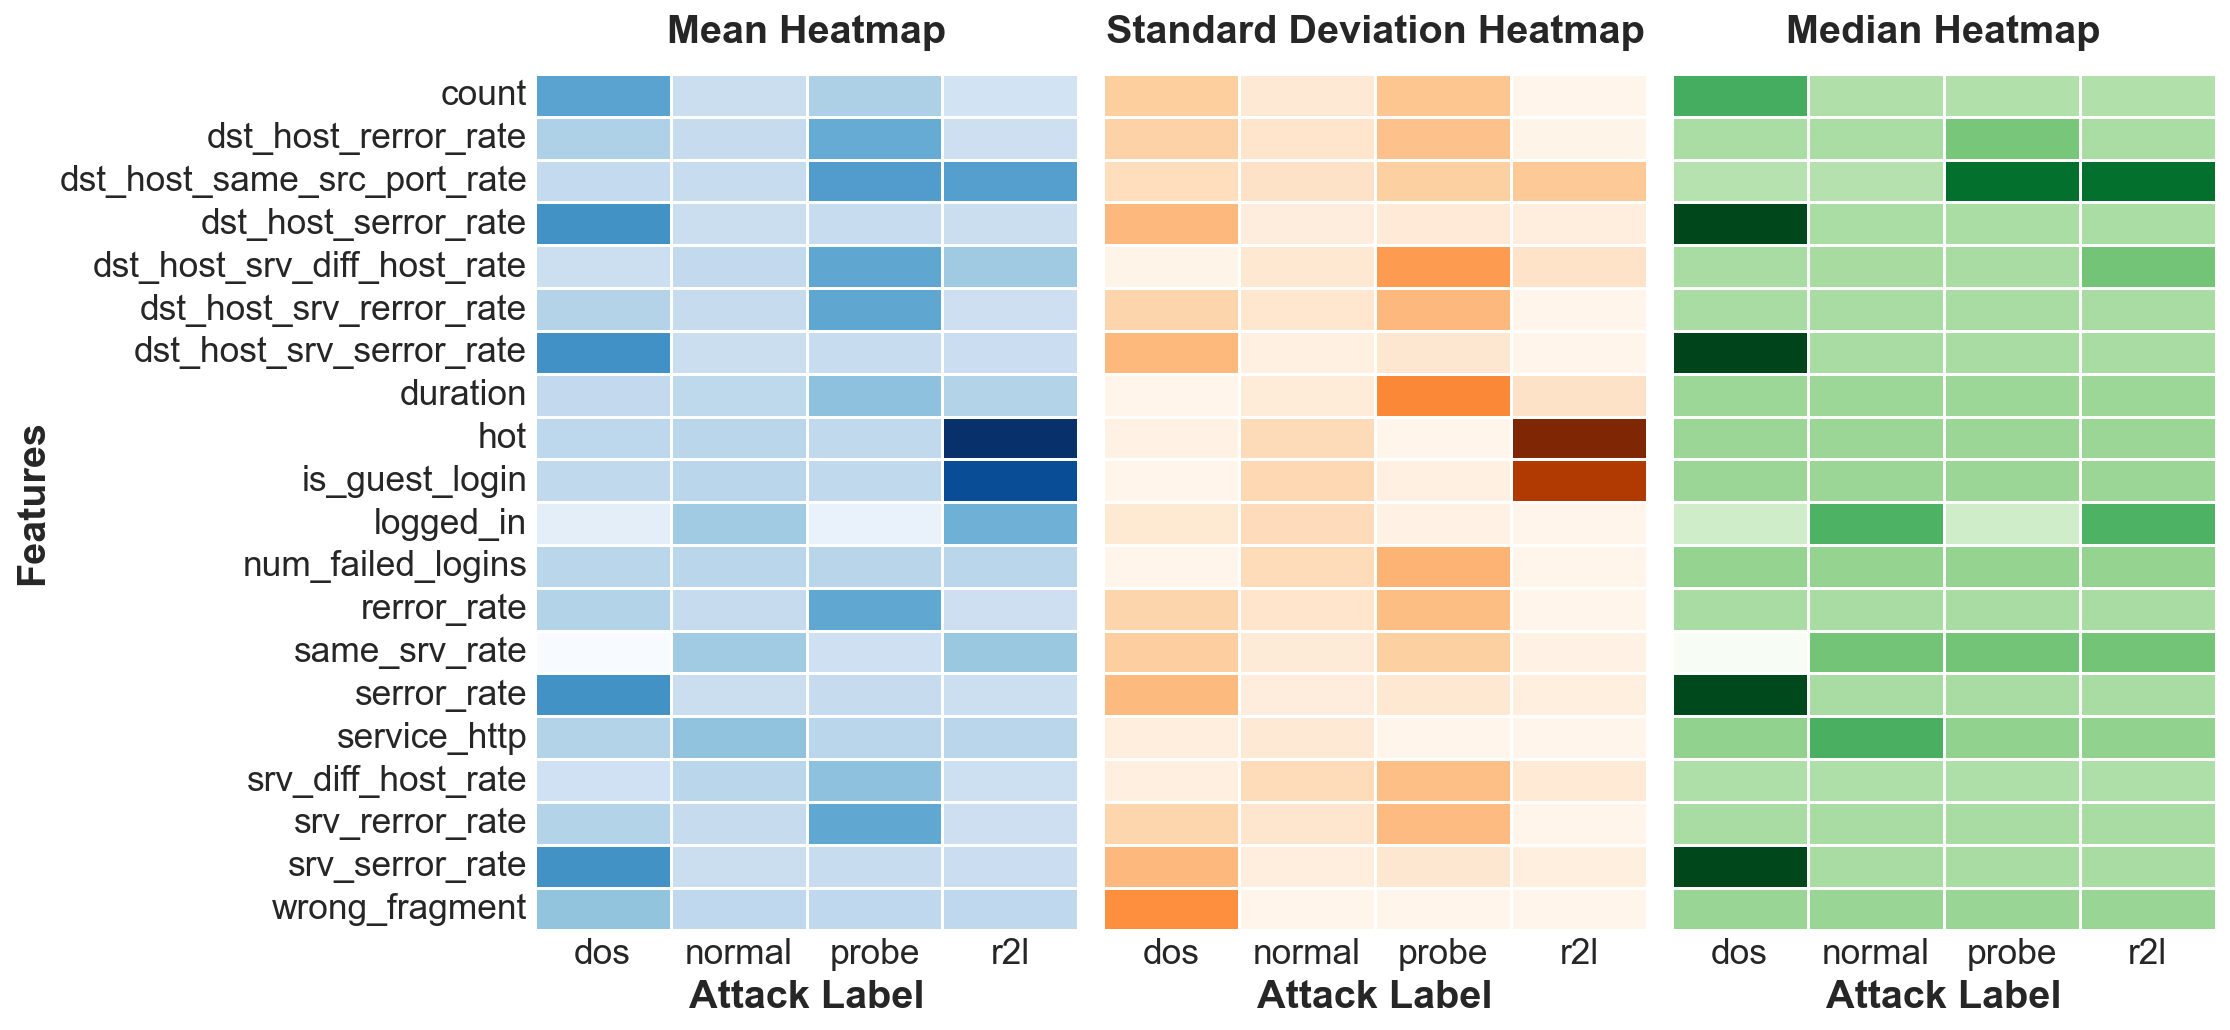

In [ ]:
significant_columns = ['count', 'serror_rate', 'srv_serror_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'same_srv_rate',
'srv_diff_host_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'num_failed_logins', 'logged_in', 'hot', 'duration',
'wrong_fragment', 'is_guest_login', 'rerror_rate', 'srv_rerror_rate', 'service_http']
significant_columns.sort()
# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 7), sharey=True)

# Mean heatmap
sns.heatmap(label_feature_means[significant_columns].T, cmap="Blues", annot=False, cbar=False,
            xticklabels=label_encoder.classes_, linewidth=.5, ax=axes[0])
axes[0].set_title("Mean Heatmap", fontsize=19, fontweight='bold', pad=15)
axes[0].set_xlabel("Attack Label", fontsize=19, fontweight='bold')
axes[0].set_ylabel("Features", fontsize=19, fontweight='bold')
axes[0].set_xticklabels(axes[0].get_xmajorticklabels(), size=17)
axes[0].set_yticklabels(axes[0].get_yticks(), size=17)

# Standard Deviation heatmap
sns.heatmap(label_feature_std[significant_columns].T, cmap="Oranges", annot=False, cbar=False,
            xticklabels=label_encoder.classes_, linewidth=.5, ax=axes[1])
axes[1].set_title("Standard Deviation Heatmap", fontsize=19, fontweight='bold', pad=15)
axes[1].set_xlabel("Attack Label", fontsize=19, fontweight='bold')
axes[1].set_xticklabels(axes[1].get_xmajorticklabels(), size=17)

# Median heatmap
sns.heatmap(label_feature_median[significant_columns].T, cmap="Greens", annot=False, cbar=False,
            xticklabels=label_encoder.classes_,  linewidth=.5,ax=axes[2])
axes[2].set_title("Median Heatmap", fontsize=19, fontweight='bold', pad=15)
axes[2].set_xlabel("Attack Label", fontsize=19, fontweight='bold')
axes[2].set_xticklabels(axes[2].get_xmajorticklabels(), size=17)

plt.tight_layout()
save_figure_for_report('task1_heatmaps_combined.png')
plt.show()

### Question 3: Domain Expert Analysis
**Q: Looking at the different heatmaps, do you find any main characteristics that are strongly correlated with a specific attack?**

**Answer:**
The heatmaps (Mean, Standard Deviation, and Median) provide insights into feature behavior per class:
- **Mean Heatmap:** Shows the average value of features for each attack type. High mean values in specific features (like `count` or `srv_count` for DoS attacks) indicate a strong correlation.
- **Standard Deviation Heatmap:** Highlights the variability of features. High variability might indicate unstable behavior characteristic of certain attacks.
- **Median Heatmap:** Offers a robust view of central tendency, less affected by outliers than the mean.
- **Observation:** Specific features likely show distinct patterns for 'dos', 'probe', and 'r2l' compared to 'normal' traffic, which helps in distinguishing them. For instance, DoS attacks often exhibit high traffic rates (high counts), while Probe attacks might show different patterns in connection duration or error rates.

In [152]:
out_dir = Path("../data/preprocessed")
out_dir.mkdir(parents=True, exist_ok=True)

# Save preprocessed splits
df_train_preprocessed.to_csv(out_dir / "train_preprocessed.csv", index=False)
df_val_preprocessed.to_csv(out_dir / "val_preprocessed.csv", index=False)
df_test_preprocessed.to_csv(out_dir / "test_preprocessed.csv", index=False)